In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss, recall_score, precision_score, mean_squared_error, r2_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.frozen import FrozenEstimator
import shap

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) 
sns.set_theme(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')

In [70]:
#load data
cvd_data = pd.read_csv('data/cardio_data.csv', delimiter=';')

In [71]:
print("=== Dataset Info ===")
cvd_data.info()

print("=== Summary Statistics ===")
display(cvd_data.describe())

print("=== Unique Value Counts ===")
display(cvd_data.nunique())

print("=== Head ===")
display(cvd_data.head())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
=== Summary Statistics ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


=== Unique Value Counts ===


id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

=== Head ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [72]:
#make a copy of data
cleaned_cvd_data = pd.DataFrame(cvd_data)

cleaned_cvd_data.age = cleaned_cvd_data.age // 365
cleaned_cvd_data.gender = cleaned_cvd_data.gender.replace({1:0, 2:1})

#remove rows with error
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_hi'] > 0)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_lo'] > 0)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_hi'] > cleaned_cvd_data["ap_lo"])]

#create BMI feature
cleaned_cvd_data["height_m"] = cleaned_cvd_data["height"] / 100
cleaned_cvd_data["bmi"] = cleaned_cvd_data["weight"] / (cleaned_cvd_data["height_m"] ** 2)
cleaned_cvd_data.drop(columns=["height_m"], inplace=True)

#create pulse pressure feature
cleaned_cvd_data["pulse_pressure"] = cleaned_cvd_data["ap_hi"] - cleaned_cvd_data["ap_lo"]

In [73]:
display(cleaned_cvd_data.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
count,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000
mean,49975.839312,52.827631,0.348579,164.359693,74.115730,128.776134,81.272250,1.364697,1.225626,0.087879,0.053344,0.803424,0.494821,27.522352,47.503884
std,28843.591732,6.769226,0.476524,8.190790,14.330403,155.061818,9.573336,0.678900,0.571486,0.283121,0.224721,0.397412,0.499977,6.067868,154.585100
min,0.000000,29.000000,0.000000,55.000000,11.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,4.000000
25%,25007.250000,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,50019.500000,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.346494,40.000000
75%,74865.750000,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.119376,50.000000
max,99999.000000,64.000000,1.000000,250.000000,200.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,15940.000000


In [74]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_cols = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure']
ordinal_cols = ['cholesterol', 'gluc']
binary_cols = ['gender', 'smoke', 'alco', 'active']

EDA


Text(0.5, 1.0, 'Count by Age Group')

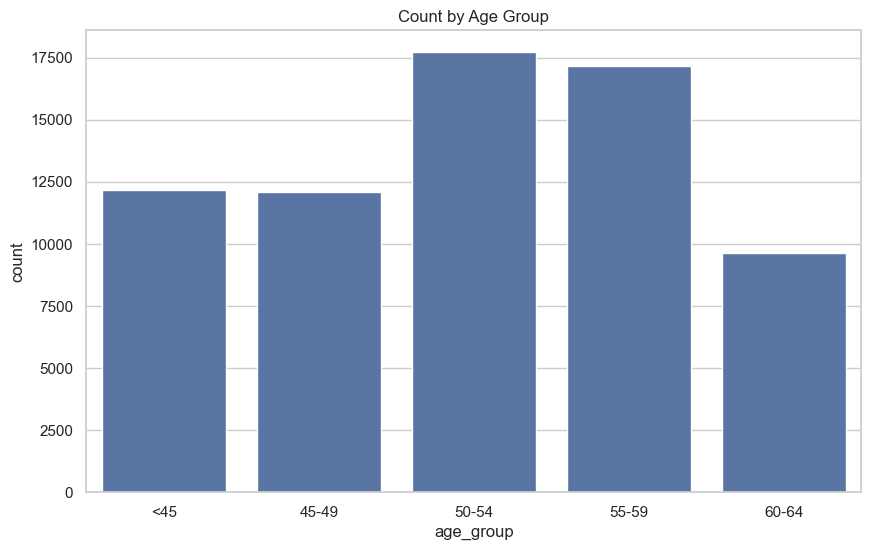

In [75]:
age_group_bin = [0, 45, 50, 55, 60, 65]
age_group_labels = ['<45', '45-49', '50-54', '55-59', '60-64']

cleaned_cvd_data['age_group'] = pd.cut(
    cleaned_cvd_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

sns.countplot(data=cleaned_cvd_data, x='age_group', order=age_group_labels)
plt.title('Count by Age Group')

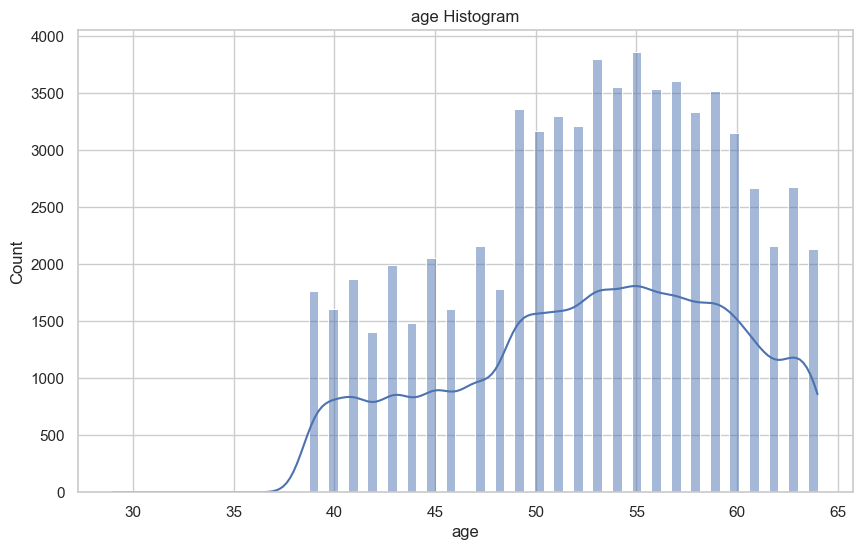

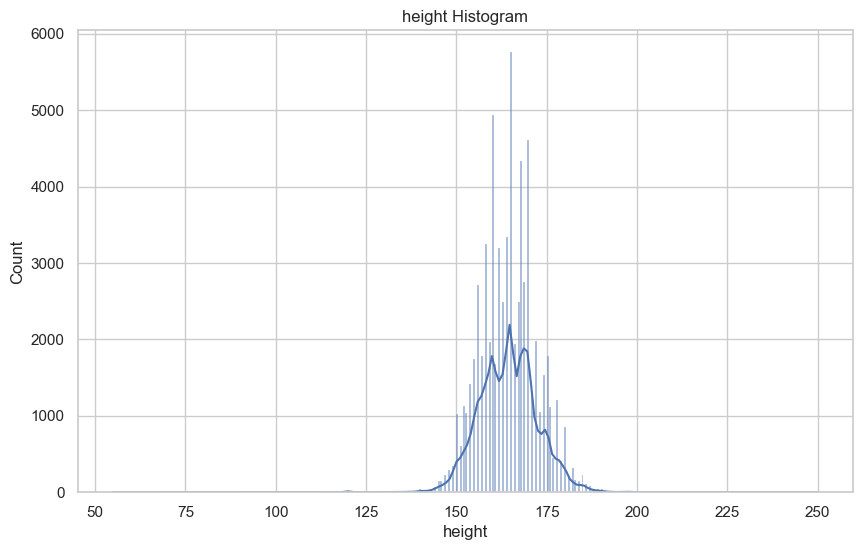

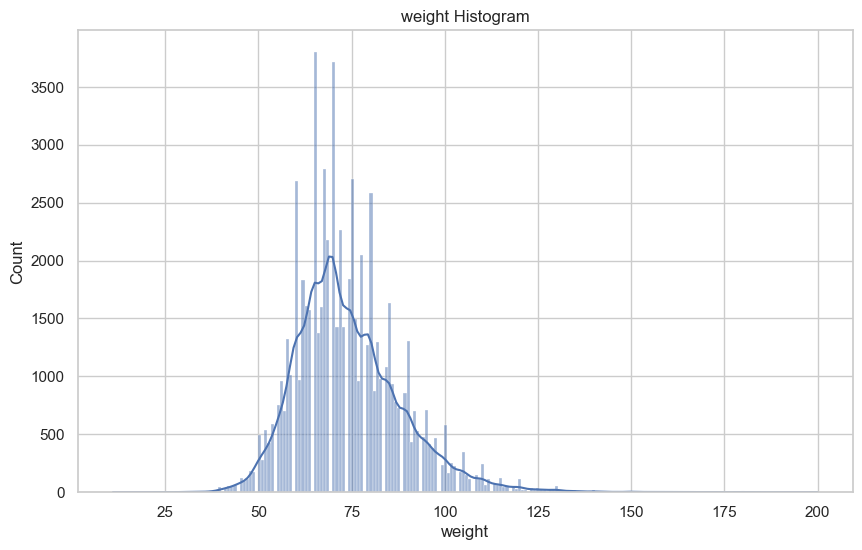

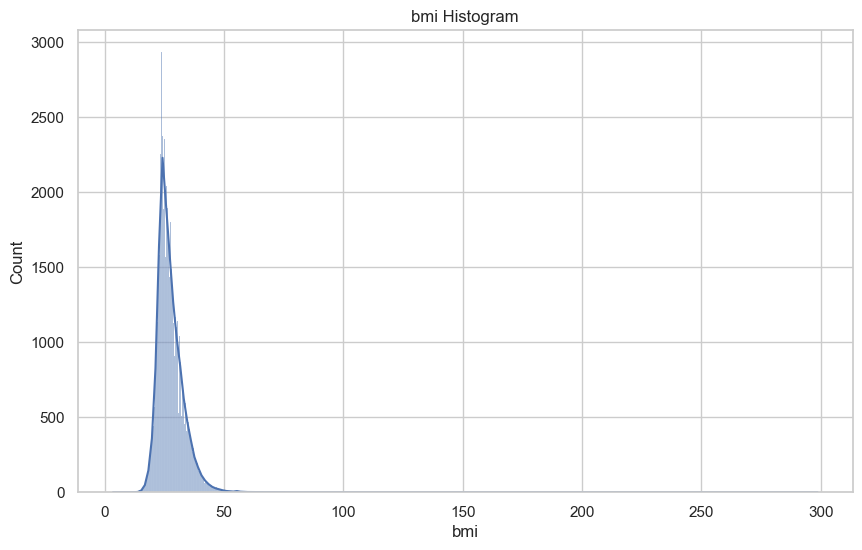

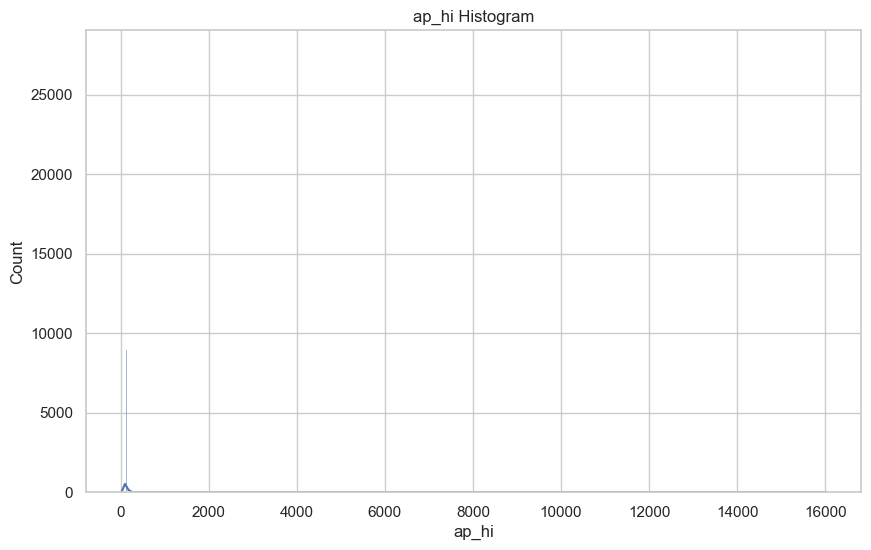

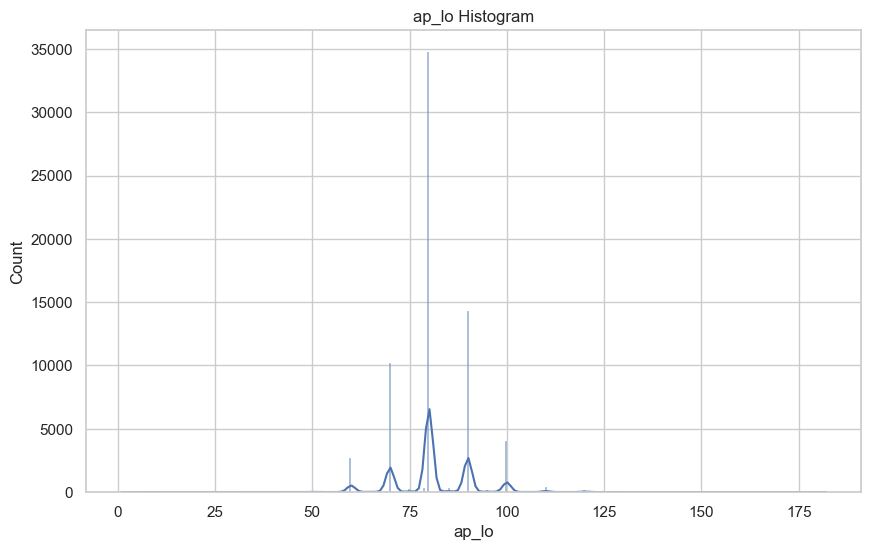

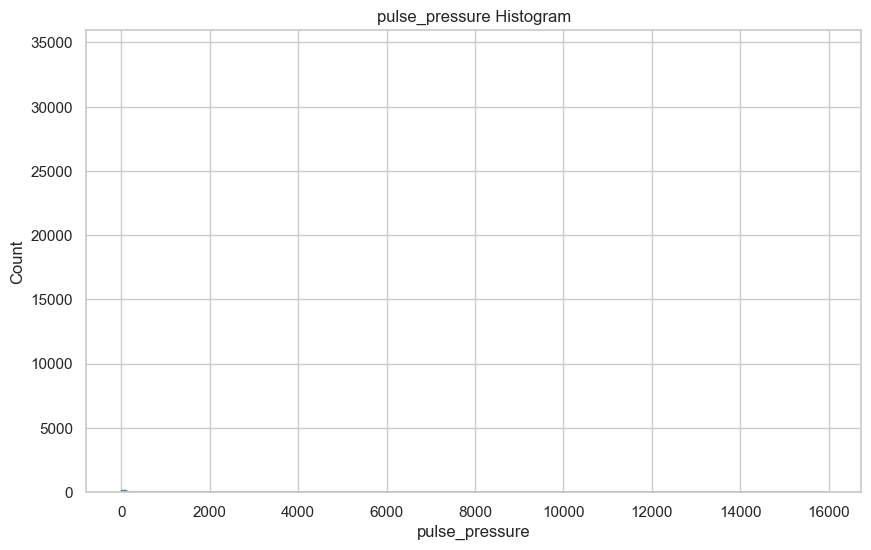

In [76]:
for col in cont_cols:
    sns.histplot(data=cleaned_cvd_data, x = col, kde = True)
    plt.title(f'{col} Histogram')
    plt.show()

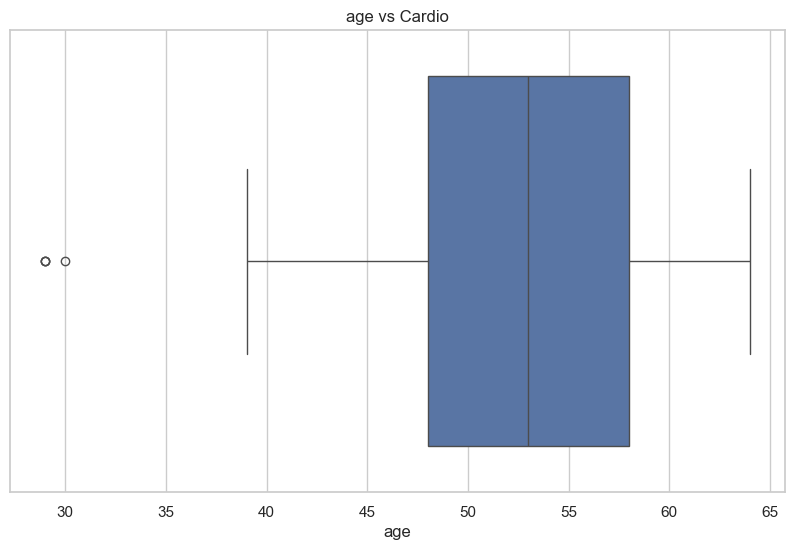

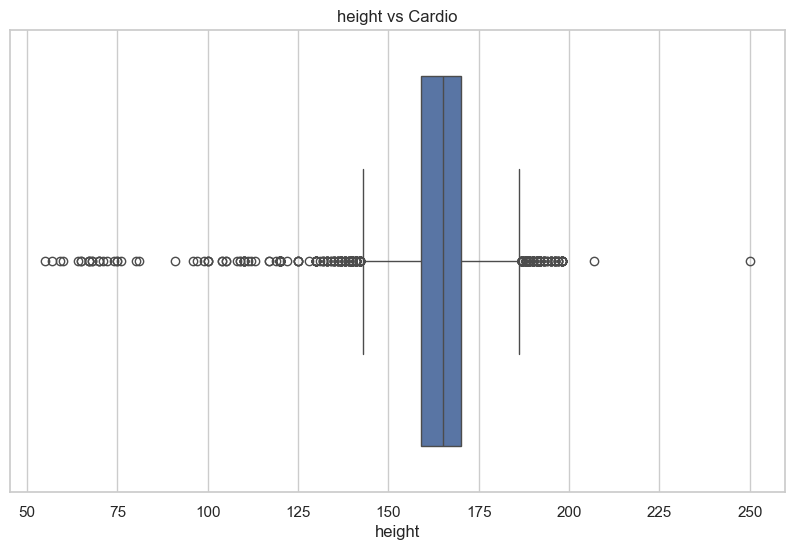

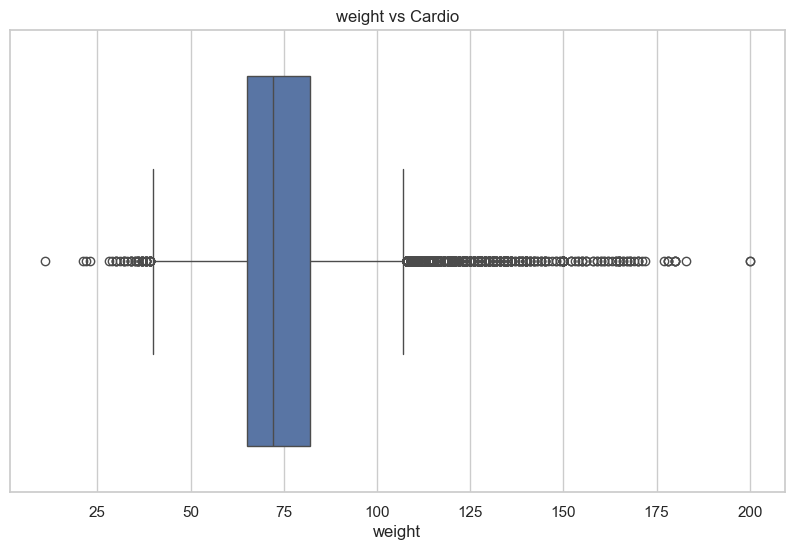

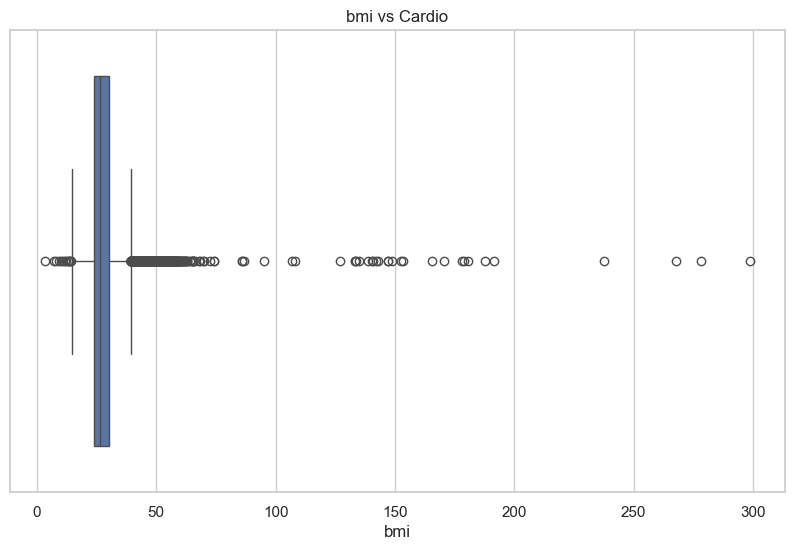

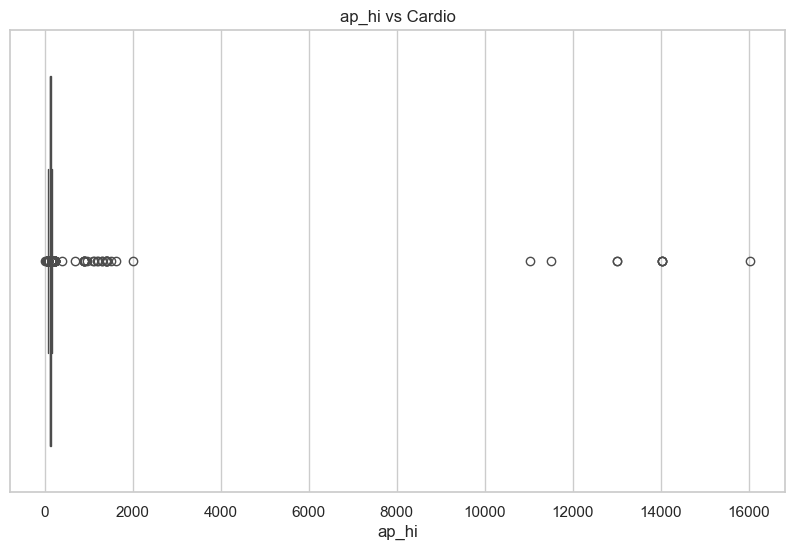

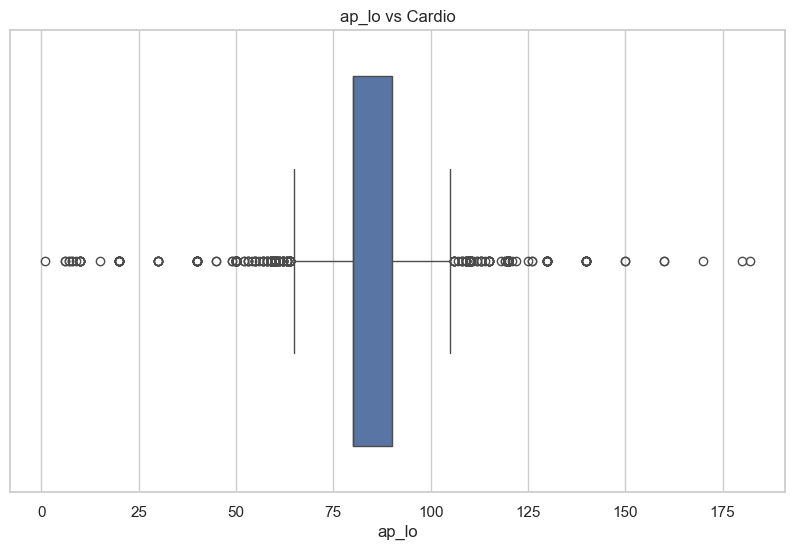

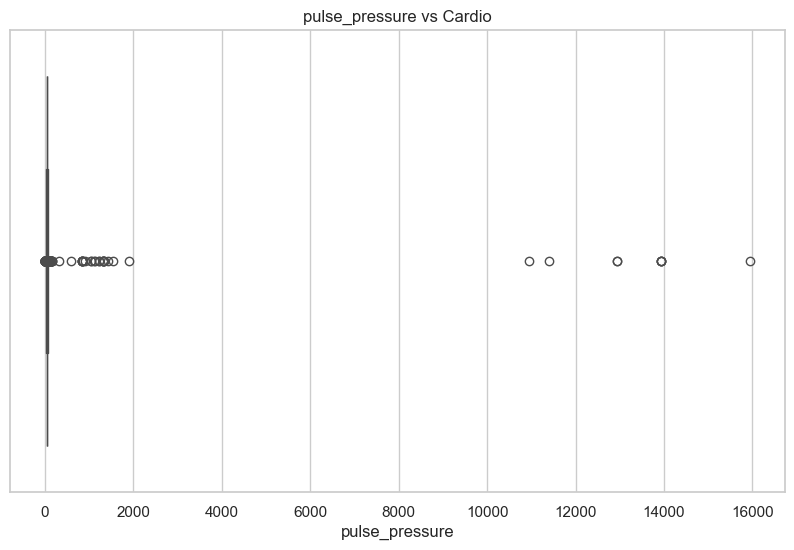

In [77]:
#Boxplot for continuous features
for col in cont_cols:
    sns.boxplot(data = cleaned_cvd_data, x = col)
    plt.title(f"{col} vs Cardio")
    plt.show()

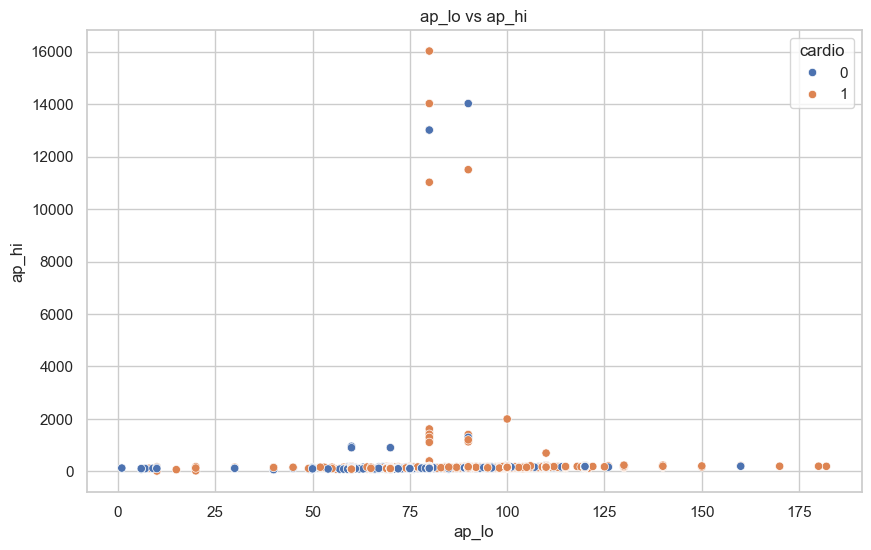

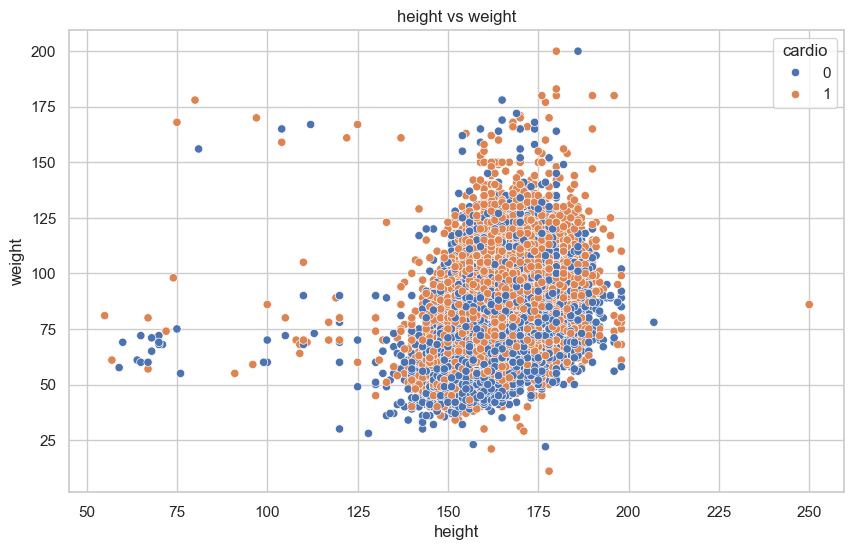

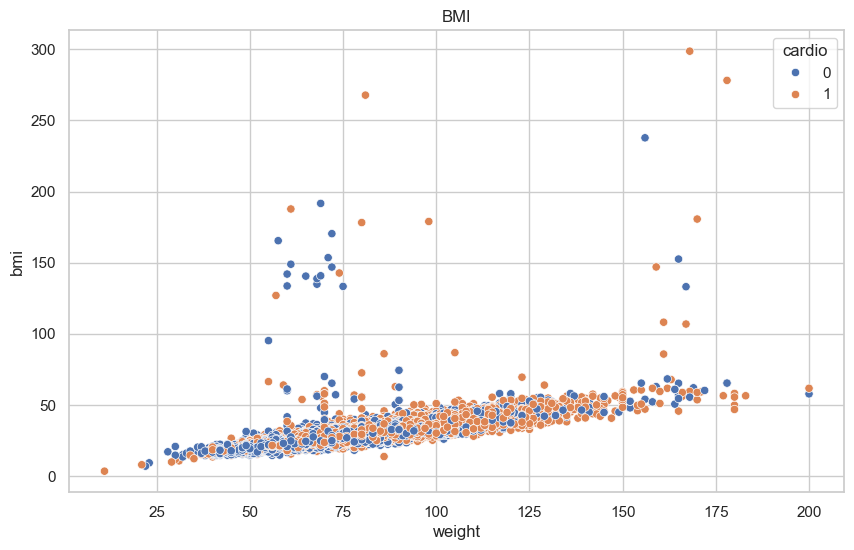

In [78]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x='height', y='weight', hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.title('BMI')
plt.show()

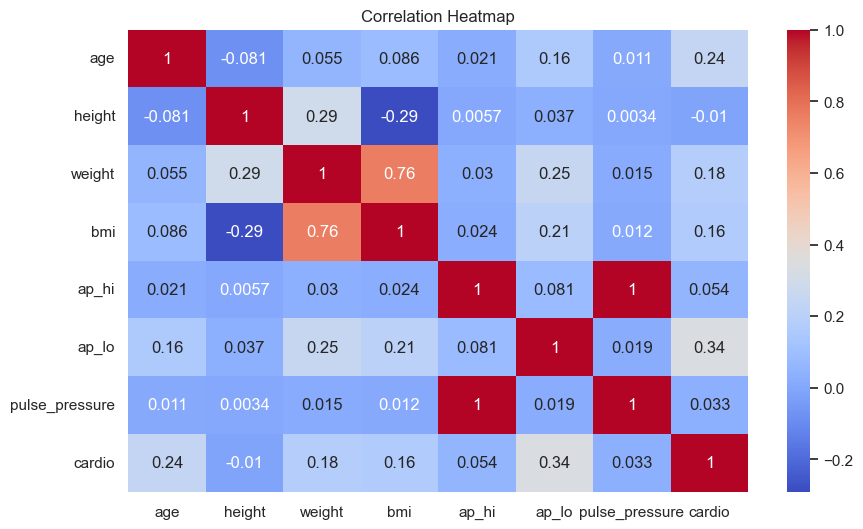

In [79]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Observation**:
- ap_hi, ap_lo, weight and height has outlier and contains unrealistic data.
- 50 > ap_hi > 220 is not valid,  source: https://www.jupiterfamilypractice.com/what-is-a-good-blood-pressure/
- 35 > ap_lo > 130 is not valid, source: https://www.jupiterfamilypractice.com/what-is-a-good-blood-pressure/
- 10 > bmi > 80 is not valid, source: https://www.hse.ie/eng/services/list/2/primarycare/east-coast-diabetes-service/management-of-type-2-diabetes/lifestyle-management/healthy-eating-advice/bmi-chart.pdf
- bmi and weight is highly correlated. must drop one of them

In [80]:
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_hi <= 220) & (cleaned_cvd_data.ap_hi >= 50)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_lo <= 130) & (cleaned_cvd_data.ap_lo >= 35)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.pulse_pressure <= 120) & (cleaned_cvd_data.pulse_pressure >= 10)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.bmi <= 80) & (cleaned_cvd_data.bmi >= 10)]

display(cleaned_cvd_data.shape)
display(f"Dropped: {cvd_data.shape[0] - cleaned_cvd_data.shape[0]} rows as outliers")

(68598, 16)

'Dropped: 1402 rows as outliers'

In [81]:
display(cleaned_cvd_data.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
count,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000
mean,49976.899866,52.828333,0.348582,164.397256,74.104958,126.632045,81.284163,1.364573,1.225750,0.087903,0.053311,0.803332,0.494519,27.463031,45.347882
std,28848.738295,6.769525,0.476525,7.978969,14.280105,16.591540,9.370395,0.678886,0.571646,0.283156,0.224654,0.397482,0.499974,5.268158,11.597545
min,0.000000,29.000000,0.000000,91.000000,28.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.726644,10.000000
25%,24998.500000,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,50019.500000,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.346494,40.000000
75%,74877.750000,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.119376,50.000000
max,99999.000000,64.000000,1.000000,250.000000,200.000000,220.000000,130.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,74.380165,120.000000


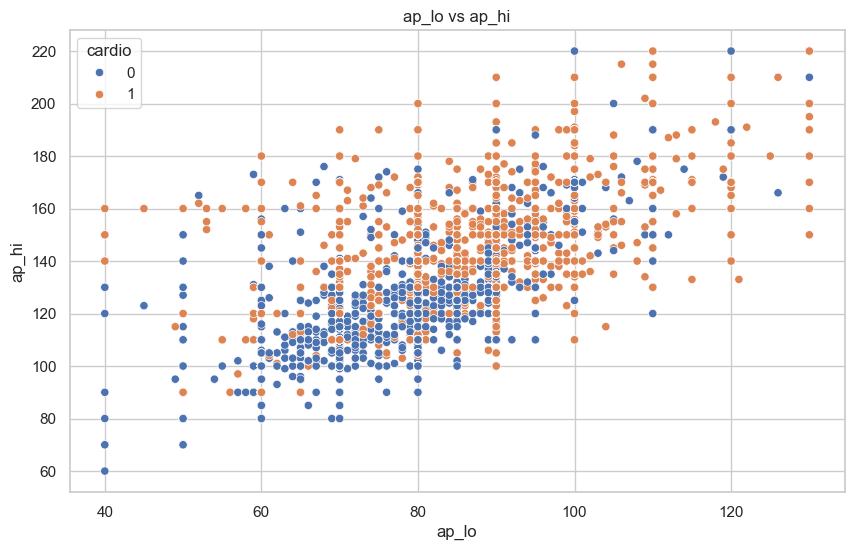

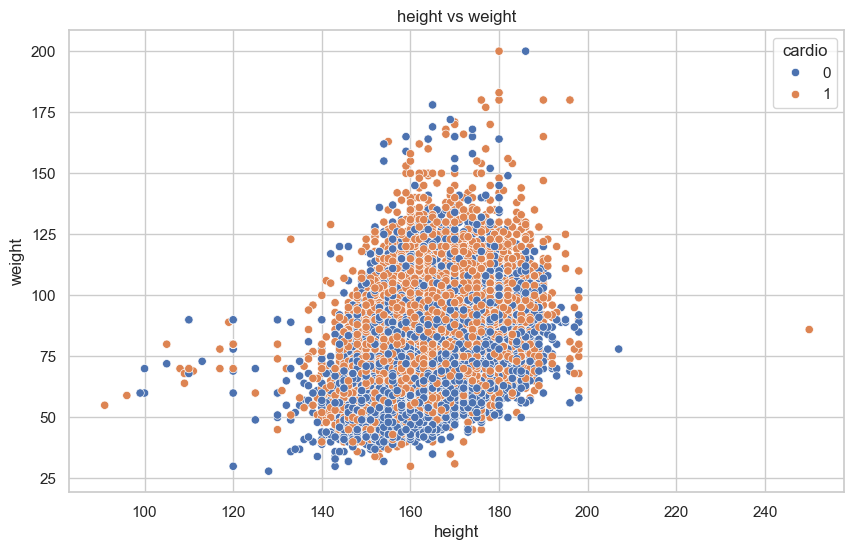

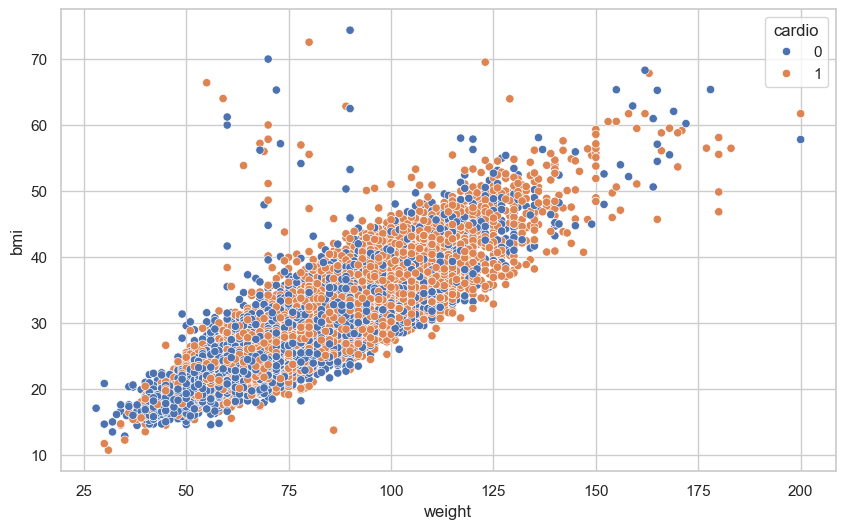

In [82]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x="height", y="weight", hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.show()

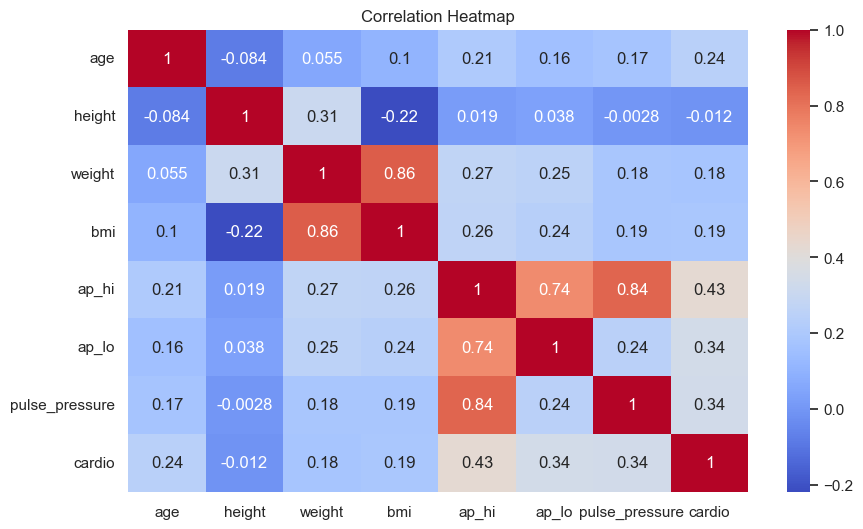

In [83]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Categorical Feature EDA


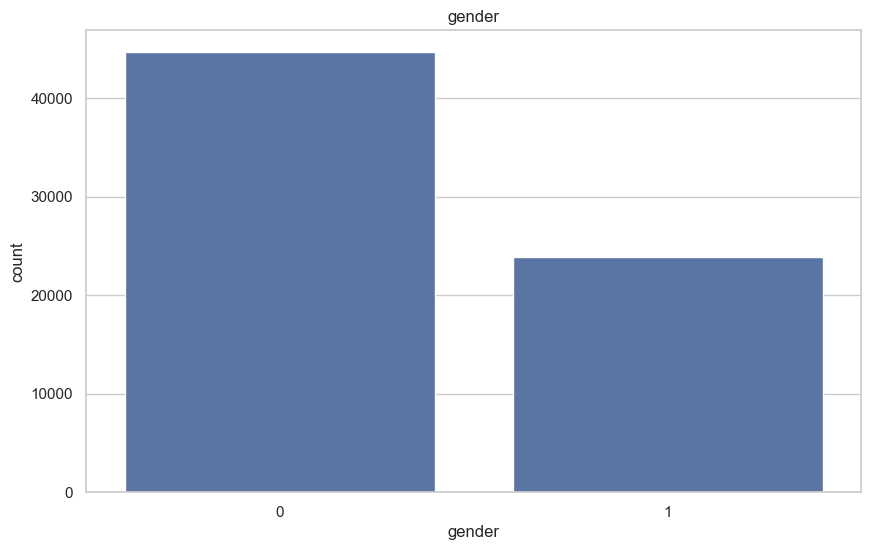

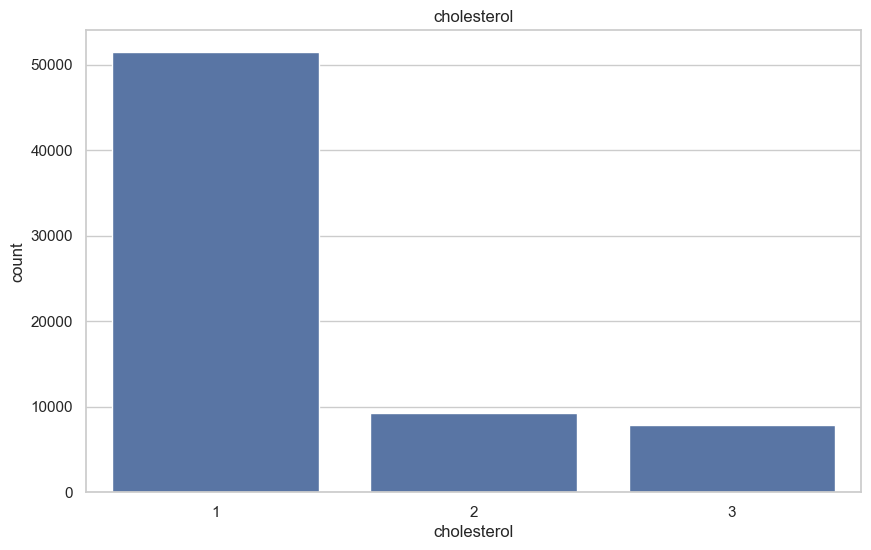

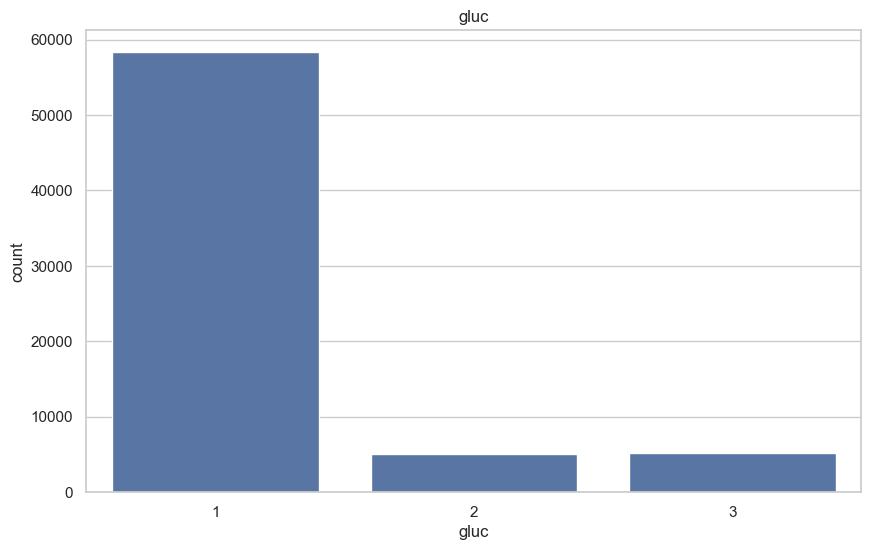

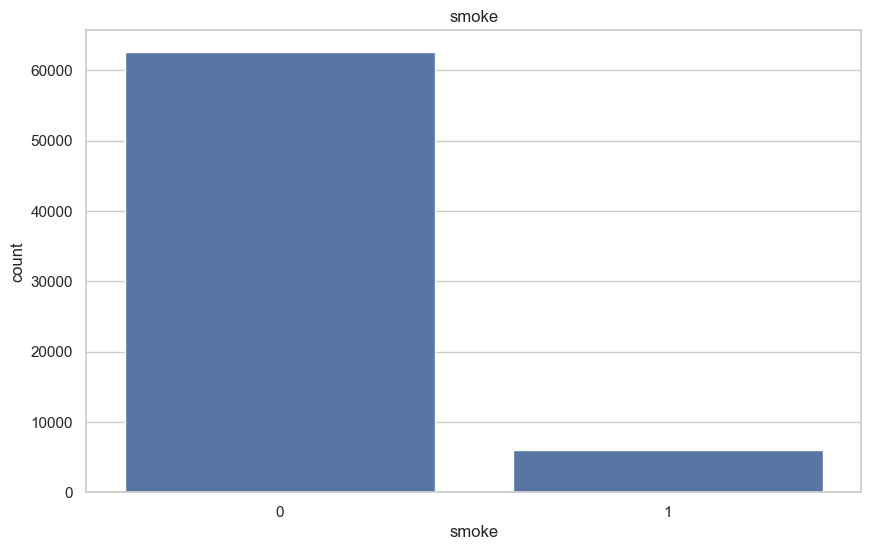

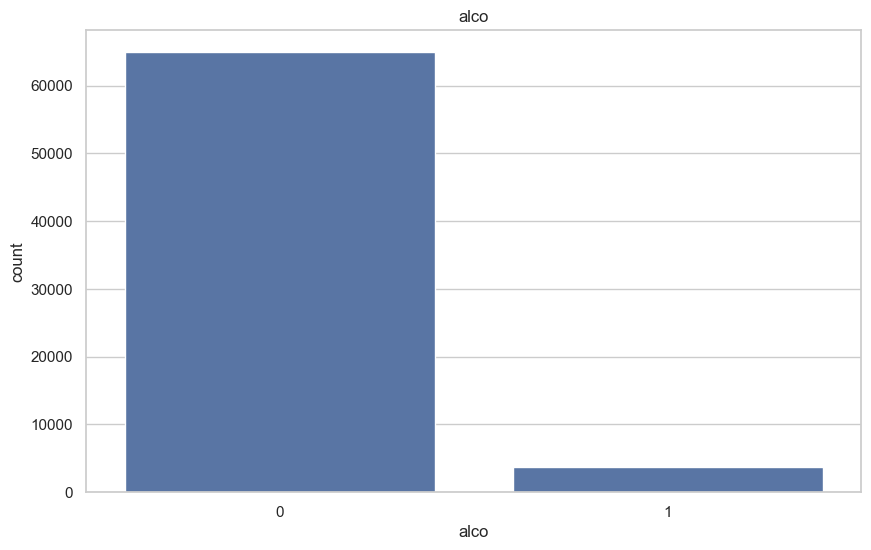

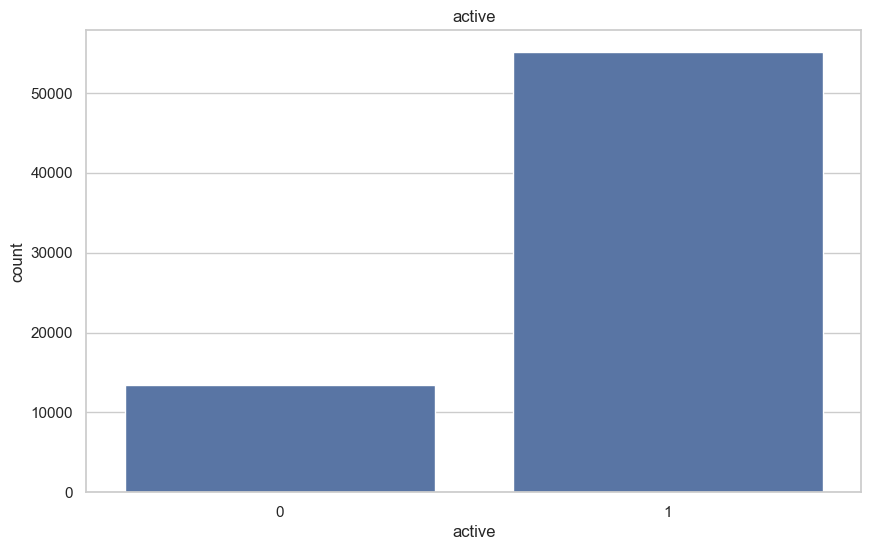

In [84]:
#Countplot of categorical features
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col)
    plt.title(f"{col}")
    plt.show()

Bivariate EDA


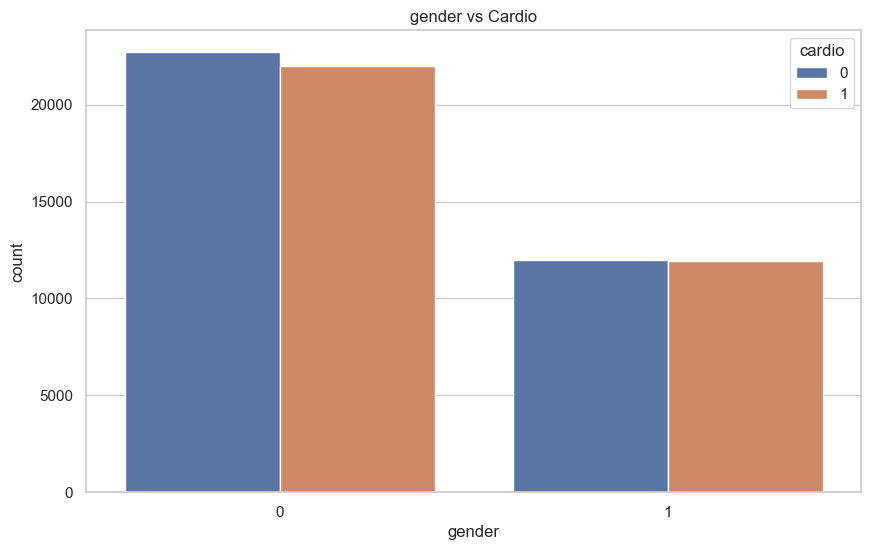

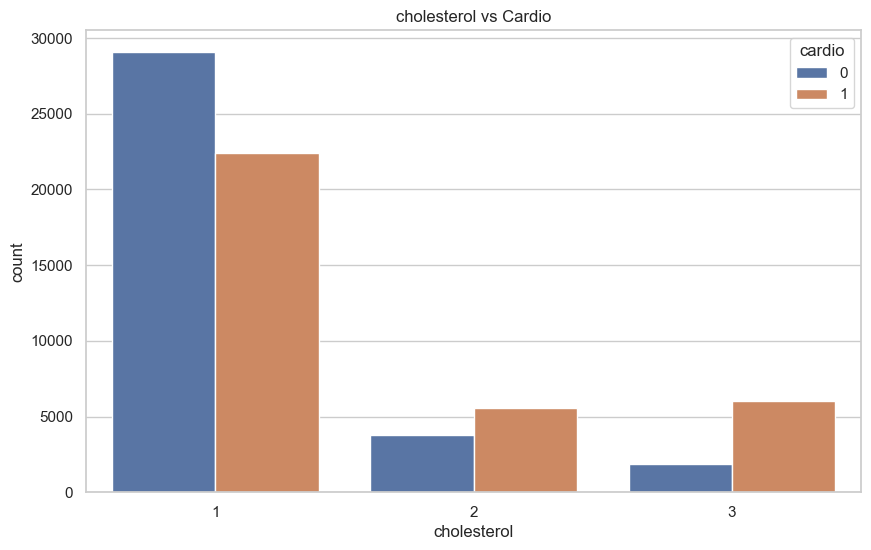

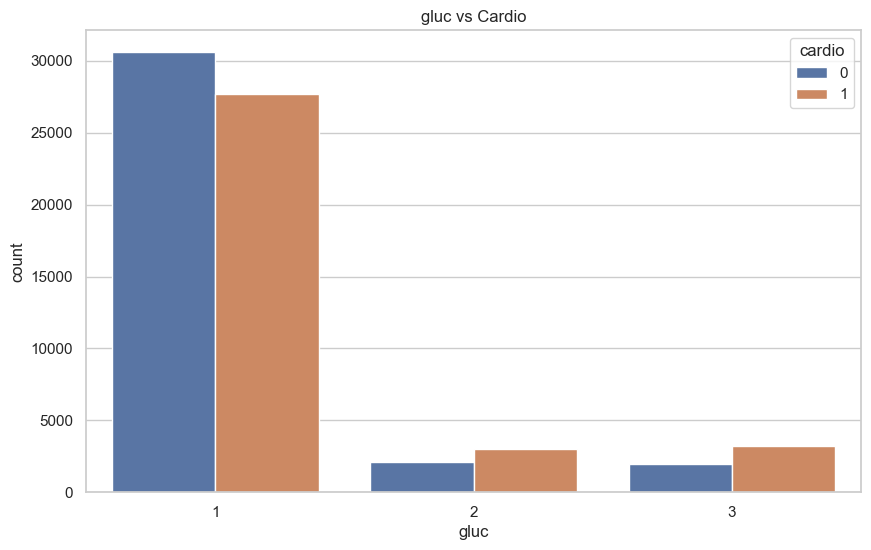

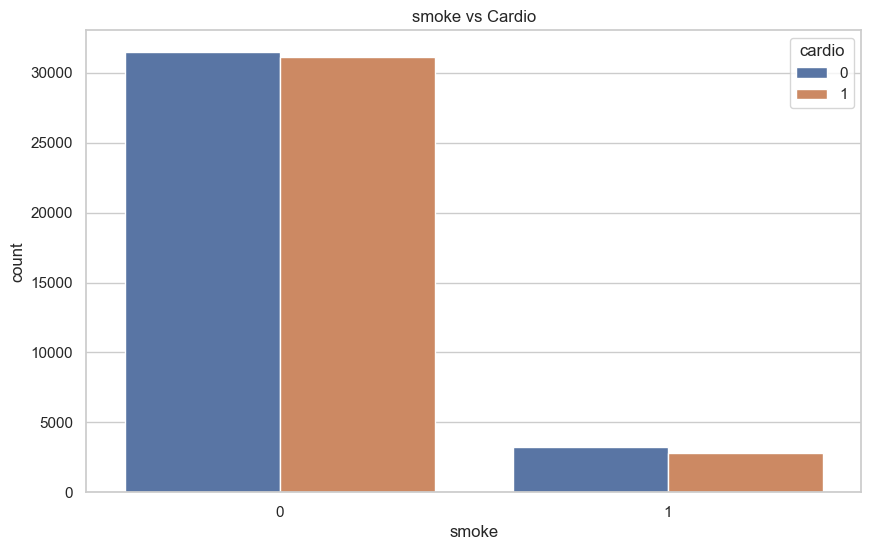

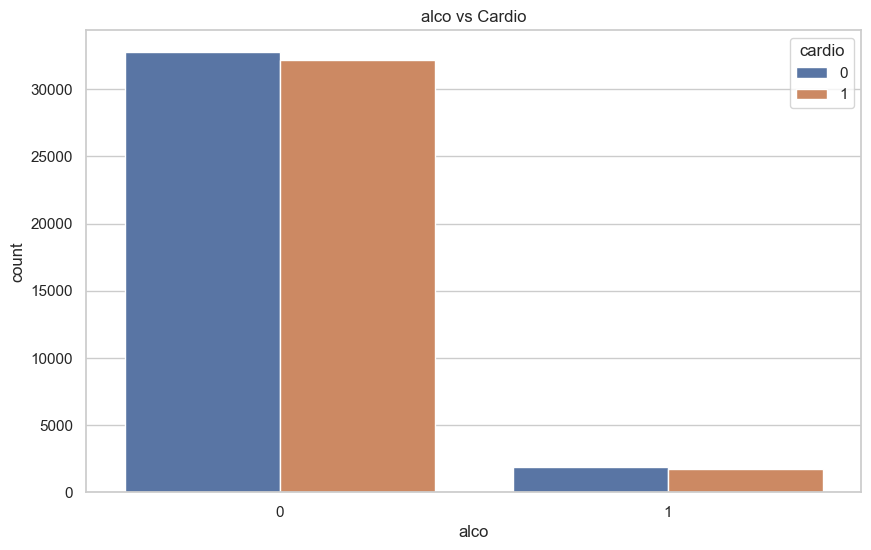

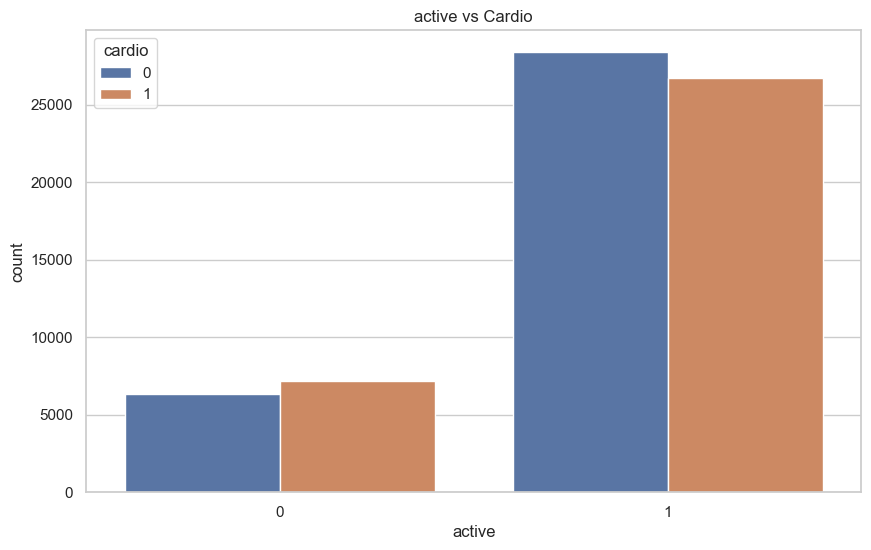

In [85]:
# relation between categorical features and cardio
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

<Axes: xlabel='cardio', ylabel='count'>

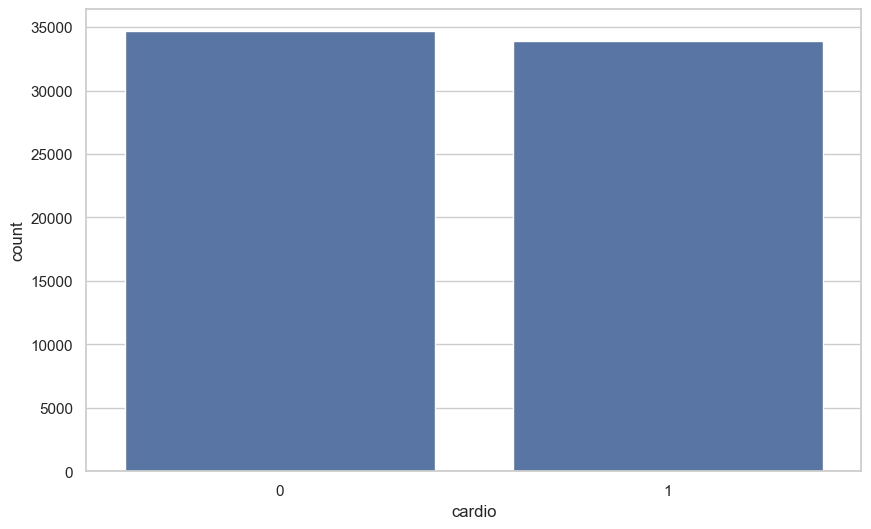

In [86]:
# Target Feature Distribution
sns.countplot(data=cleaned_cvd_data,x='cardio')

In [87]:
display(cvd_data[cvd_data.cardio == 1])

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
15,24,16782,2,172,112.0,120,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


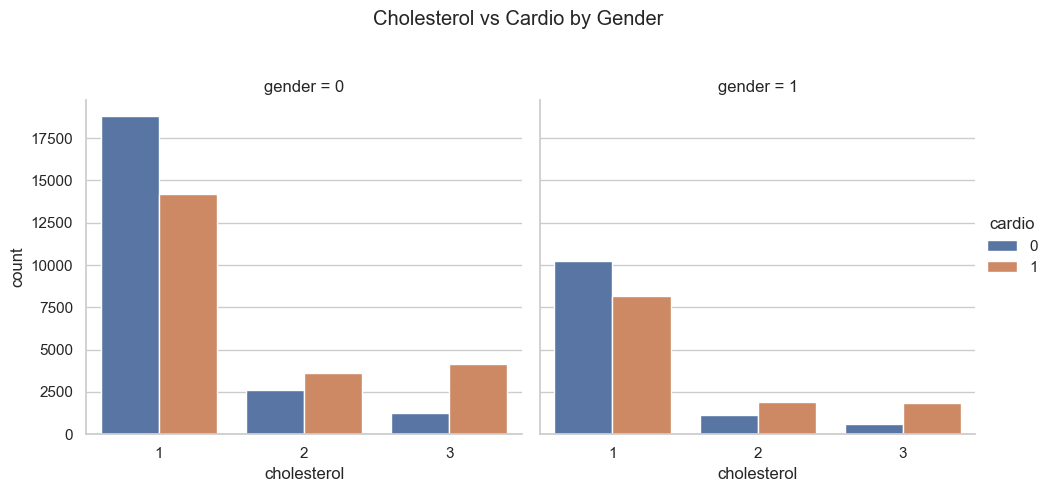

In [88]:
sns.catplot(x='cholesterol', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Cholesterol vs Cardio by Gender')
plt.show()

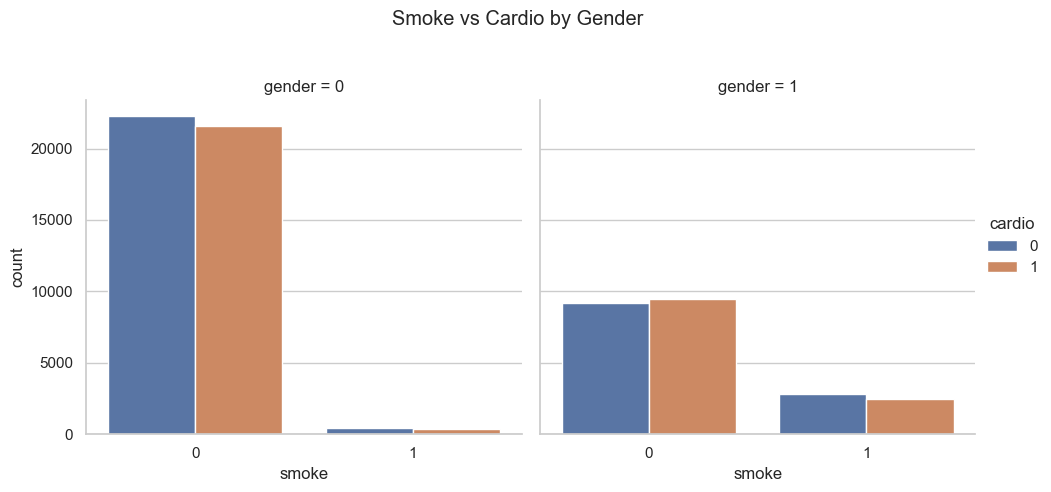

In [89]:
sns.catplot(x='smoke', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Smoke vs Cardio by Gender')
plt.show()

Split Train Validation Test: 70/10/20

In [90]:
#stratify on age, gender and cardio for fairness
cleaned_cvd_data['stratify_col'] = cleaned_cvd_data['cardio'].astype(str) + '_' + cleaned_cvd_data['gender'].astype(str) + '_' + cleaned_cvd_data['age_group'].astype(str)

In [91]:
train_validation_data, test_data = train_test_split(
    cleaned_cvd_data,
    test_size=0.20,
    stratify=cleaned_cvd_data['stratify_col'],
    random_state=42
)

In [92]:
train_data, validation_data = train_test_split(train_validation_data, test_size=0.125, stratify=train_validation_data['stratify_col'], random_state=42)

In [93]:
#drop unnecessary columns
drop_cols = ['id', 'stratify_col', 'age_group', 'bmi', 'pulse_pressure']
cont_cols.remove('bmi')
cont_cols.remove('pulse_pressure')

train_data.drop(columns=drop_cols, inplace=True)
validation_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

In [94]:
X_train = train_data.drop('cardio', axis=1)
y_train = train_data['cardio']

X_validation = validation_data.drop('cardio', axis=1)
y_validation = validation_data['cardio']

X_test = test_data.drop('cardio', axis=1)
y_test = test_data['cardio']

Model Preprocessor
- Scaling Numeric columns
-  One Hot Encoding ordinal columns

In [95]:
pre_processor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), cont_cols),
    ('cat', OneHotEncoder(), ordinal_cols),
    ('pass', 'passthrough', binary_cols)
], remainder='drop', verbose_feature_names_out=False)

Model Training without Hyperparameter Tuning

In [96]:
models_untuned = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier())
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True))
    ])
}

In [97]:
model_names = ['logistic_regression', 'knn', 'random_forest', 'xgboost', 'svc']
score_metrics = ['accuracy', 'recall_score', 'rmse', 'r2', 'precision_score', 'f1_score', 'roc_auc', 'brier_score']

In [98]:
def get_results(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
    
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    cm = confusion_matrix(y, y_pred, normalize='true')
    
    return pd.Series({
        'accuracy': accuracy,
        'rmse': rmse,
        'r2': r2,
        'recall_score': recall,
        'precision_score': precision,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'prob_true': prob_true,
        'prob_pred': prob_pred
    })

In [99]:
results_untuned = pd.DataFrame()

for name, model in models_untuned.items():
    print(f"Training tuned model: {name} : Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
    model.fit(X_train, y_train)
    results_untuned[name] = get_results(model, X_test, y_test)

display(results_untuned.loc[score_metrics])

Training tuned model: logistic_regression : Training on 48018 samples, Testing on 13720 samples
Training tuned model: knn : Training on 48018 samples, Testing on 13720 samples
Training tuned model: random_forest : Training on 48018 samples, Testing on 13720 samples
Training tuned model: xgboost : Training on 48018 samples, Testing on 13720 samples
Training tuned model: svc : Training on 48018 samples, Testing on 13720 samples


,logistic_regression,knn,random_forest,xgboost,svc
accuracy,0.725729,0.690962,0.697303,0.7293,0.732434
recall_score,0.657678,0.672119,0.680961,0.678014,0.666225
rmse,0.523709,0.555912,0.550179,0.520288,0.517267
r2,-0.097212,-0.236295,-0.210928,-0.082925,-0.070387
precision_score,0.756056,0.693583,0.699198,0.750571,0.76278
f1_score,0.703444,0.682682,0.689959,0.71245,0.71124
roc_auc,0.788845,0.737897,0.757563,0.79155,0.785922
brier_score,0.18774,0.219647,0.205809,0.185298,0.18695


Hyperparameter Tuning with 5 fold grid search cross validation

In [100]:
#cross validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [101]:
gs_models = {
    'svc': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', SVC(random_state=42))
        ]),
        'param_grid': [
            {
                'model__kernel': ['linear', 'rbf'],
                'model__C': [0.1, 1, 10],
                'model__gamma': ['scale', 'auto', 0.001, 0.01],
            },
        ]
    },
    'logistic_regression': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', LogisticRegression(random_state=42))
        ]),
        'param_grid': [
            {
                'model__penalty': ['l1'],
                'model__solver': ['liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['l2'],
                'model__solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': [None],
                'model__solver': ['lbfgs', 'newton-cg', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['elasticnet'],
                'model__solver': ['saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__l1_ratio': [0.1, 0.5, 0.9],
                'model__max_iter': [1000, 2000, 3000, 5000]            
            }
        ]
    },
    'knn': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', KNeighborsClassifier())
        ]),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            'model__weights': ['uniform', 'distance',],
            'model__p': [1, 2],
        }
    },
    'random_forest': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 20, 30, None],
            'model__bootstrap': [True],
            'model__criterion': ['gini'],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'xgboost': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__min_child_weight': [1, 5, 10],
            'model__gamma': [0.0, 0.1, 0.5],
            'model__subsample': [0.8],
            'model__colsample_bytree': [0.8],
            'model__reg_alpha': [0, 0.01],
            'model__eval_metric': ['logloss']
        }
    },
}

In [102]:
grid_search_results = {}

for name, gs in gs_models.items():
    print(f"Running grid search for: {name}")
    gs = GridSearchCV(gs['pipeline'], gs['param_grid'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best_params_clean = {k.replace('model__', ''): v for k, v in gs.best_params_.items()}
    
    grid_search_results[name] = {
        'best_params': best_params_clean,
        'best_score': gs.best_score_,
        'best_estimator': gs.best_estimator_
    }

Running grid search for: svc
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Running grid search for: logistic_regression
Fitting 5 folds for each of 364 candidates, totalling 1820 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1

Running grid search for: knn
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Running grid search for: random_forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running grid search for: xgboost
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [103]:
for name, res in grid_search_results.items():
    print(f"Best parameters for {name}: {res['best_params']}")
    print(f"Best ROC-AUC for {name}: {res['best_score']:.4f}")

Best parameters for svc: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best ROC-AUC for svc: 0.7948
Best parameters for logistic_regression: {'C': np.float64(10.0), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC-AUC for logistic_regression: 0.7922
Best parameters for knn: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best ROC-AUC for knn: 0.7663
Best parameters for random_forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best ROC-AUC for random_forest: 0.8003
Best parameters for xgboost: {'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0, 'subsample': 0.8}
Best ROC-AUC for xgboost: 0.8024


Final model training with best parameters

In [105]:
models = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42,**grid_search_results['logistic_regression']['best_params']))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier(**grid_search_results['knn']['best_params']))
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42, **grid_search_results['random_forest']['best_params']))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42,  **grid_search_results['xgboost']['best_params']))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True, random_state=42, **grid_search_results['svc']['best_params']))
    ])
}

In [106]:
for name, pipeline in models.items():
    print(f"Training tuned model: {name} : Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
    pipeline.fit(X_train, y_train)

Training tuned model: logistic_regression : Training on 48018 samples, Testing on 13720 samples
Training tuned model: knn : Training on 48018 samples, Testing on 13720 samples
Training tuned model: random_forest : Training on 48018 samples, Testing on 13720 samples
Training tuned model: xgboost : Training on 48018 samples, Testing on 13720 samples
Training tuned model: svc : Training on 48018 samples, Testing on 13720 samples


In [107]:
results_tuned = pd.DataFrame()
score_metrics = ['accuracy', 'recall_score', 'precision_score', 'f1_score', 'roc_auc', 'brier_score']

for name, model in models.items():    
    results_tuned[name] = get_results(model, X_test, y_test)

display(results_tuned.loc[score_metrics])

,logistic_regression,knn,random_forest,xgboost,svc
accuracy,0.725729,0.708746,0.730977,0.734329,0.726385
recall_score,0.657678,0.679929,0.65812,0.672856,0.650309
precision_score,0.756056,0.716682,0.765119,0.762143,0.76165
f1_score,0.703444,0.697822,0.707597,0.714722,0.70159
roc_auc,0.788844,0.763837,0.796383,0.798623,0.790699
brier_score,0.187739,0.201262,0.182995,0.181634,0.185398


In [195]:
model_name_mapping = {'logistic_regression': 'Logistic Regression', 'knn': 'KNN', 'random_forest': 'Random Forest', 'svc': 'SVM', 'xgboost': 'XGBoost'}
scoring_metric_name_mapping = {'accuracy': 'Accuracy', 'recall_score': 'Recall', 'precision_score': 'Precision', 'f1_score': 'F1-Score', 'roc_auc': 'ROC-AUC', 'brier_score': 'Brier Score'}

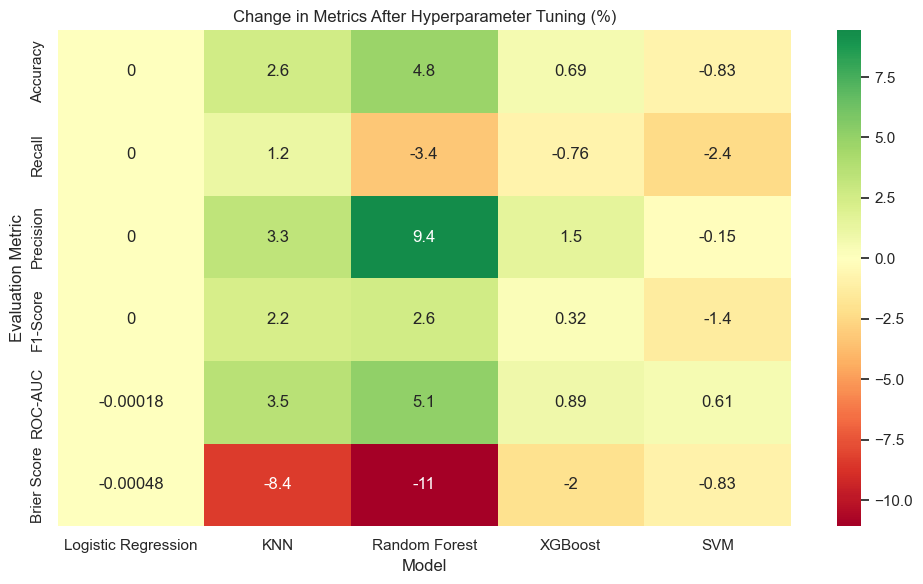

In [197]:
metrics_tuned = pd.DataFrame(results_tuned, index=score_metrics)
metrics_untuned = pd.DataFrame(results_untuned, index=score_metrics)

metrics_change_percent = ((metrics_tuned - metrics_untuned) / metrics_untuned) * 100
metrics_change_percent = metrics_change_percent.astype(float)
metrics_change_percent.rename(columns=model_name_mapping, index = scoring_metric_name_mapping, inplace=True)

sns.heatmap(metrics_change_percent, annot=True, cmap='RdYlGn', center=0)
plt.title('Change in Metrics After Hyperparameter Tuning (%)')
plt.xlabel('Model')
plt.ylabel('Evaluation Metric')
plt.tight_layout()
plt.show()

Model Calibration: isotonic, platt scaling

In [198]:
calibrated_models_isotonic = {}
calibrated_models_platt = {}

for name, model in models.items():
    print(f"Calibrating model: {name} with isotonic regression")
    iso_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic')
    iso_calibrator.fit(X_validation, y_validation)
    calibrated_models_isotonic[name] = iso_calibrator
    
    print(f"Calibrating model: {name} with Platt scaling")
    platt_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='sigmoid')
    platt_calibrator.fit(X_validation, y_validation)
    calibrated_models_platt[name] = platt_calibrator

Calibrating model: logistic_regression with isotonic regression
Calibrating model: logistic_regression with Platt scaling
Calibrating model: knn with isotonic regression
Calibrating model: knn with Platt scaling
Calibrating model: random_forest with isotonic regression
Calibrating model: random_forest with Platt scaling
Calibrating model: xgboost with isotonic regression
Calibrating model: xgboost with Platt scaling
Calibrating model: svc with isotonic regression
Calibrating model: svc with Platt scaling


In [199]:
results_calibrated_isotonic = {}
results_calibrated_platt = {}

for name, model in calibrated_models_isotonic.items():
    results_calibrated_isotonic[name] = get_results(model, X_test, y_test)

for name, model in calibrated_models_platt.items():    
    results_calibrated_platt[name] = get_results(model, X_test, y_test)

Calibration Reliability Curve

In [200]:
def display_calibration_curve(name, label, prob_true, prob_pred):
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.title(f"Calibration Curve — {name} - {label}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.grid()
    plt.show()

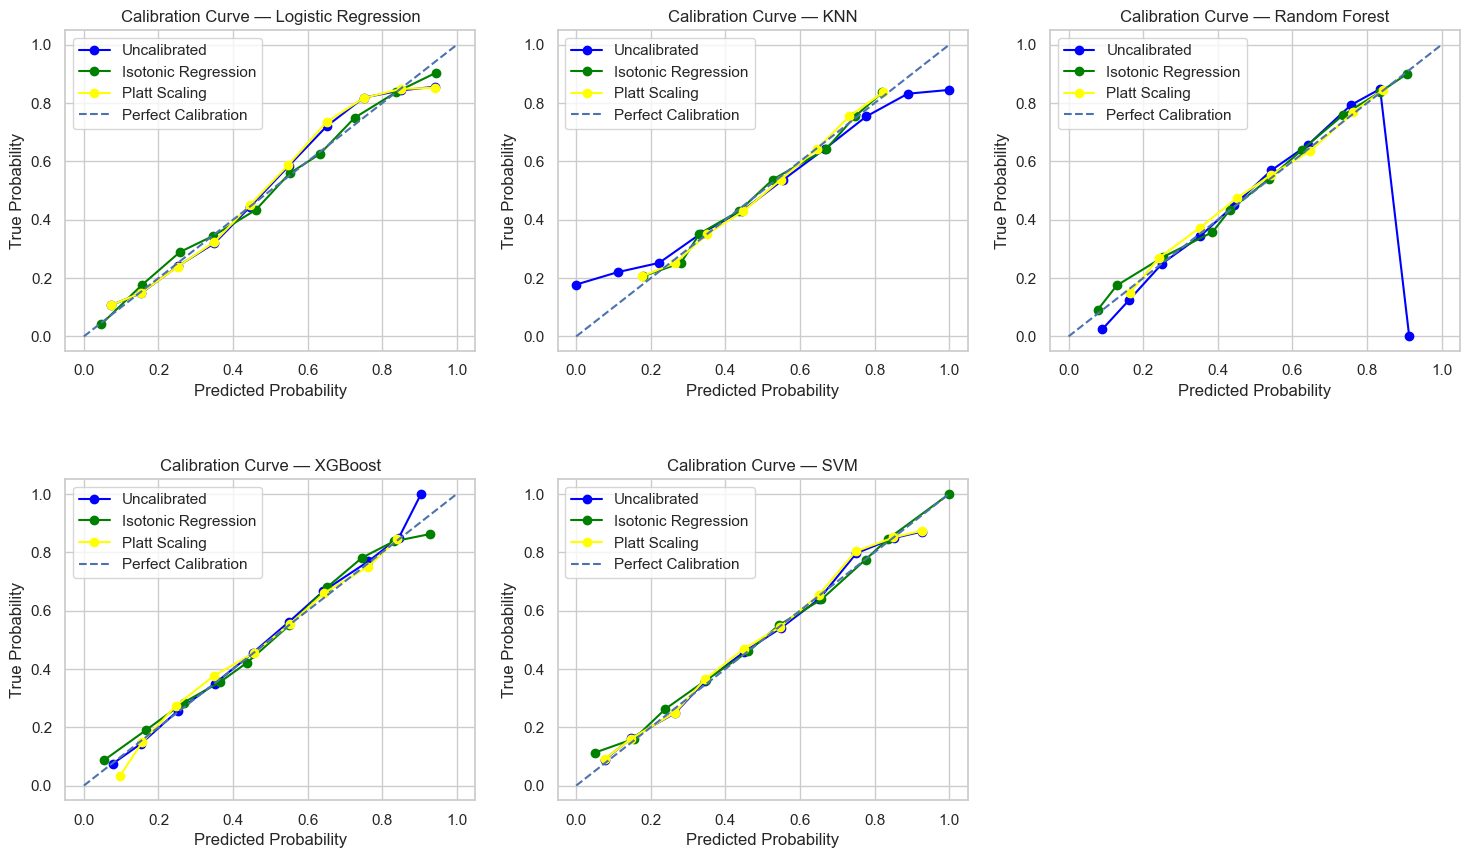

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    ax.plot(results_tuned[name]['prob_pred'], results_tuned[name]['prob_true'], marker='o', label='Uncalibrated', color='blue')
    ax.plot(results_calibrated_isotonic[name]['prob_pred'], results_calibrated_isotonic[name]['prob_true'], marker='o', label='Isotonic Regression', color='green')
    ax.plot(results_calibrated_platt[name]['prob_pred'], results_calibrated_platt[name]['prob_true'], marker='o', label='Platt Scaling', color='yellow')
    ax.plot([0, 1], [0, 1], '--', label='Perfect Calibration')

    ax.set_title(f"Calibration Curve — {model_name_mapping[name]}")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("True Probability")
    ax.legend()

for ax in axes[len(models):]:
    fig.delaxes(ax)

plt.subplots_adjust(hspace=0.4)
plt.show()

update models with calibration

In [203]:
final_models = {}
final_results = {}

for name in model_names:
    uncalibrated_brier = results_tuned[name]['brier_score']
    iso_brier = results_calibrated_isotonic[name]['brier_score']
    platt_brier = results_calibrated_platt[name]['brier_score']
    
    if uncalibrated_brier <= iso_brier and uncalibrated_brier <= platt_brier:
        final_models[name] = models[name]
        final_results[name] = results_tuned[name]
    elif iso_brier <= uncalibrated_brier and iso_brier <= platt_brier:
        final_models[name] = calibrated_models_isotonic[name]
        final_results[name] = results_calibrated_isotonic[name]
    elif platt_brier <= uncalibrated_brier and platt_brier <= iso_brier:
        final_models[name] = calibrated_models_platt[name]
        final_results[name] = results_calibrated_platt[name]

Final Model ROC-AUC Curve

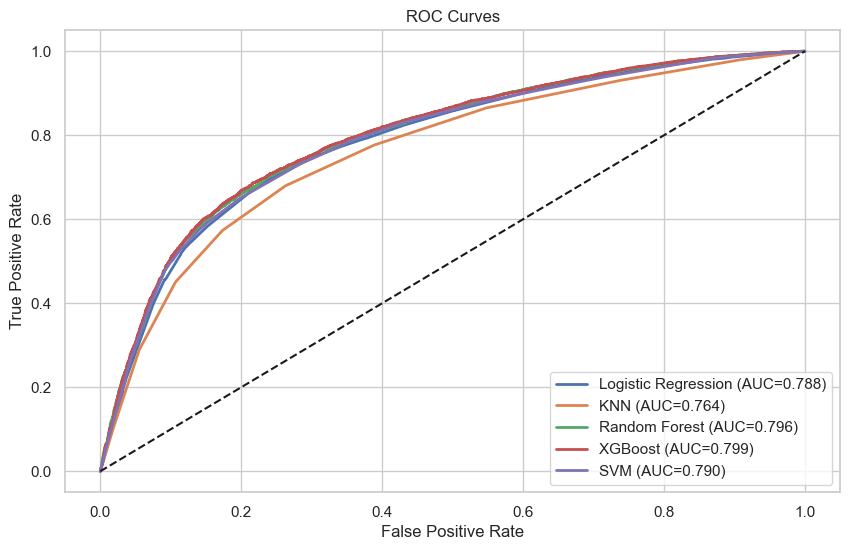

In [218]:
for name, res in final_results.items():
    fpr, tpr, _ = roc_curve(y_test, res.y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name_mapping[name]} (AUC={auc_score:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

Final Model Confusion Metrix

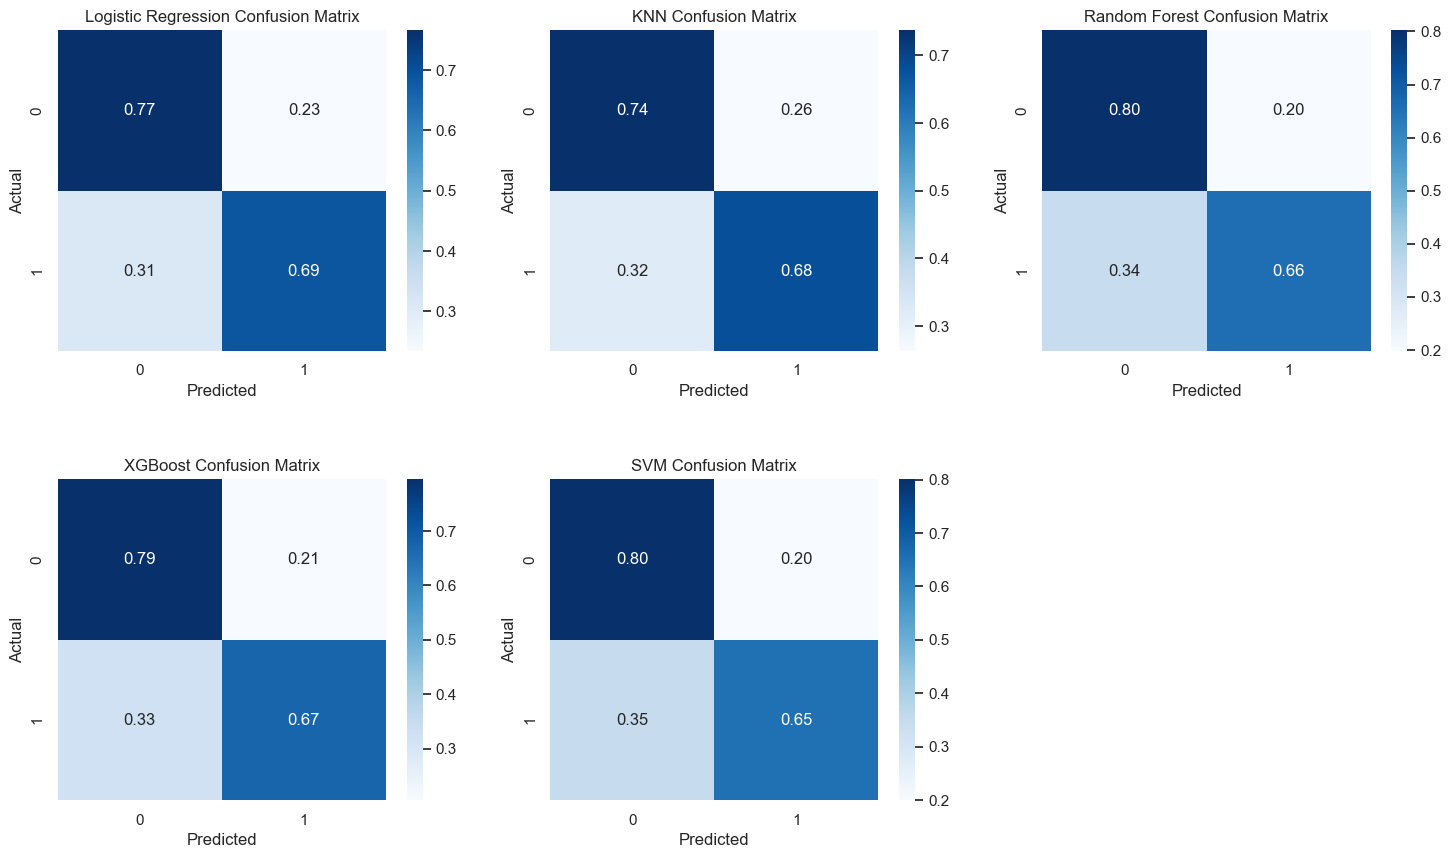

In [254]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, final_results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])

    sns.heatmap(res['confusion_matrix'], annot=True, fmt='.2f', cmap="Blues", ax=ax)
    ax.set_title(f"{model_name_mapping[name]} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

for ax in axes[len(models):]:
    fig.delaxes(ax)

plt.subplots_adjust(hspace=0.4)
plt.show()

Fairness Evaluation

'logistic_regression - Age Groups Equal Opportunity Difference (EOD): 0.3422'

'knn - Age Groups Equal Opportunity Difference (EOD): 0.2579'

'random_forest - Age Groups Equal Opportunity Difference (EOD): 0.2536'

'xgboost - Age Groups Equal Opportunity Difference (EOD): 0.3417'

'svc - Age Groups Equal Opportunity Difference (EOD): 0.2149'

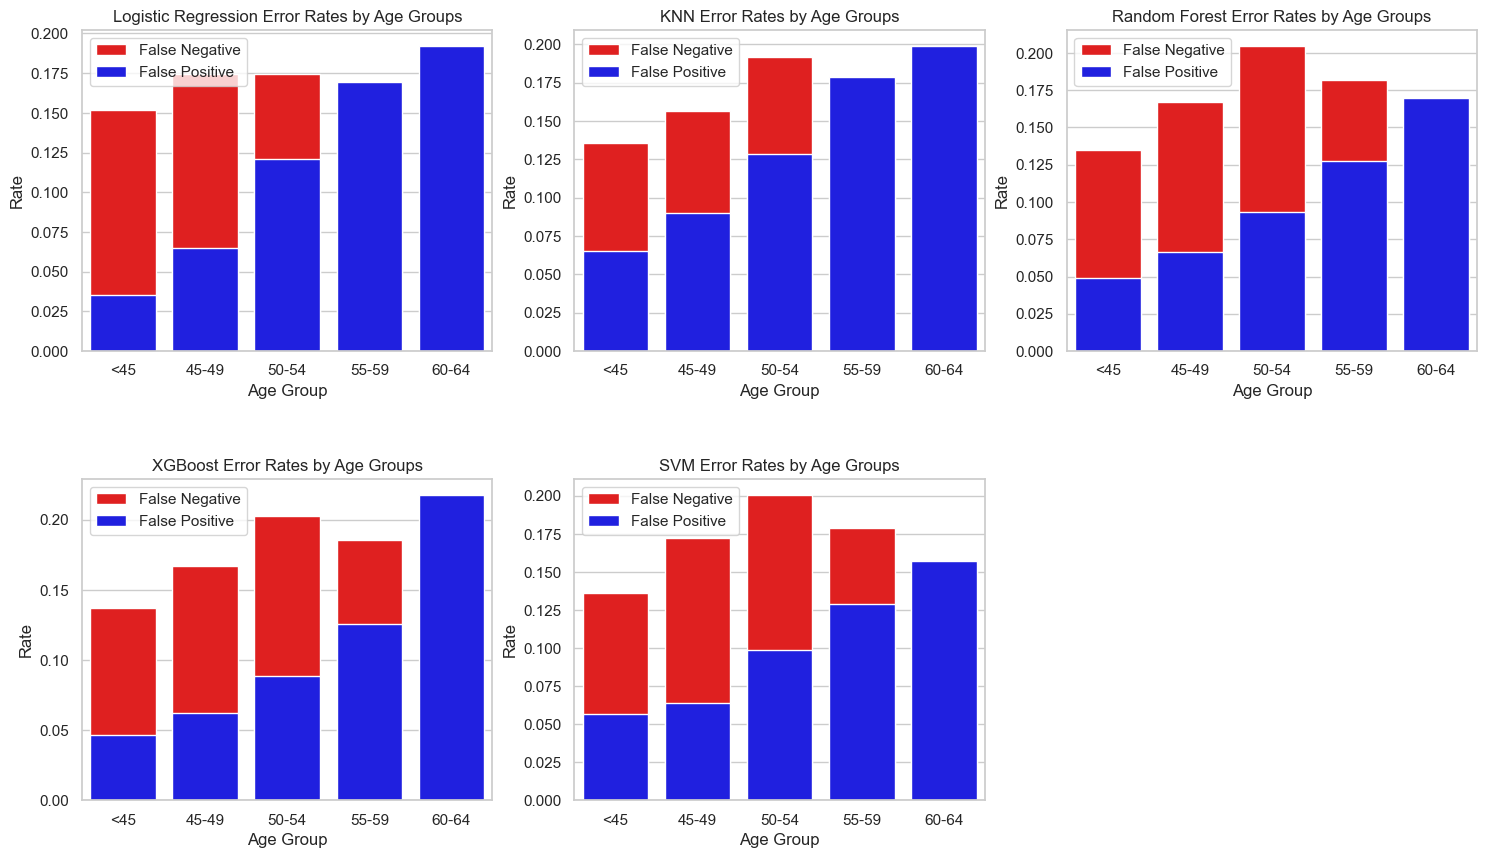

In [255]:
#age group fairness evaluation
test_data['age_group'] = pd.cut(
    test_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, final_models.items()):
    result = pd.DataFrame()

    for group in age_group_labels:
        group_indices = test_data[test_data['age_group'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        result[group] = get_results(model, X_group, y_group)
        result.loc['FN_rate', group] = ((result[group]['y_pred'] == 0) & (y_group == 1)).mean()
        result.loc['FP_rate', group] = ((result[group]['y_pred'] == 1) & (y_group == 0)).mean()
        
    age_group_eod = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    display(f"{name} - Age Groups Equal Opportunity Difference (EOD): {age_group_eod:.4f}")

    sns.barplot(x=result.columns, y=result.loc['FN_rate'], color="red", label="False Negative", ax=ax)
    sns.barplot(x=result.columns, y=result.loc['FP_rate'], color="blue", label="False Positive", ax=ax)
    ax.set_title(f"{model_name_mapping[name]} Error Rates by Age Groups")
    ax.set_xlabel("Age Group")
    ax.set_ylabel("Rate")

for ax in axes[len(models):]:
    fig.delaxes(ax)

plt.subplots_adjust(hspace=0.4)   
plt.show()

'logistic_regression - Gender Groups Equal Opportunity Difference (EOD): 0.0027'

'knn - Gender Groups Equal Opportunity Difference (EOD): 0.0035'

'random_forest - Gender Groups Equal Opportunity Difference (EOD): 0.0015'

'xgboost - Gender Groups Equal Opportunity Difference (EOD): 0.0016'

'svc - Gender Groups Equal Opportunity Difference (EOD): 0.0026'

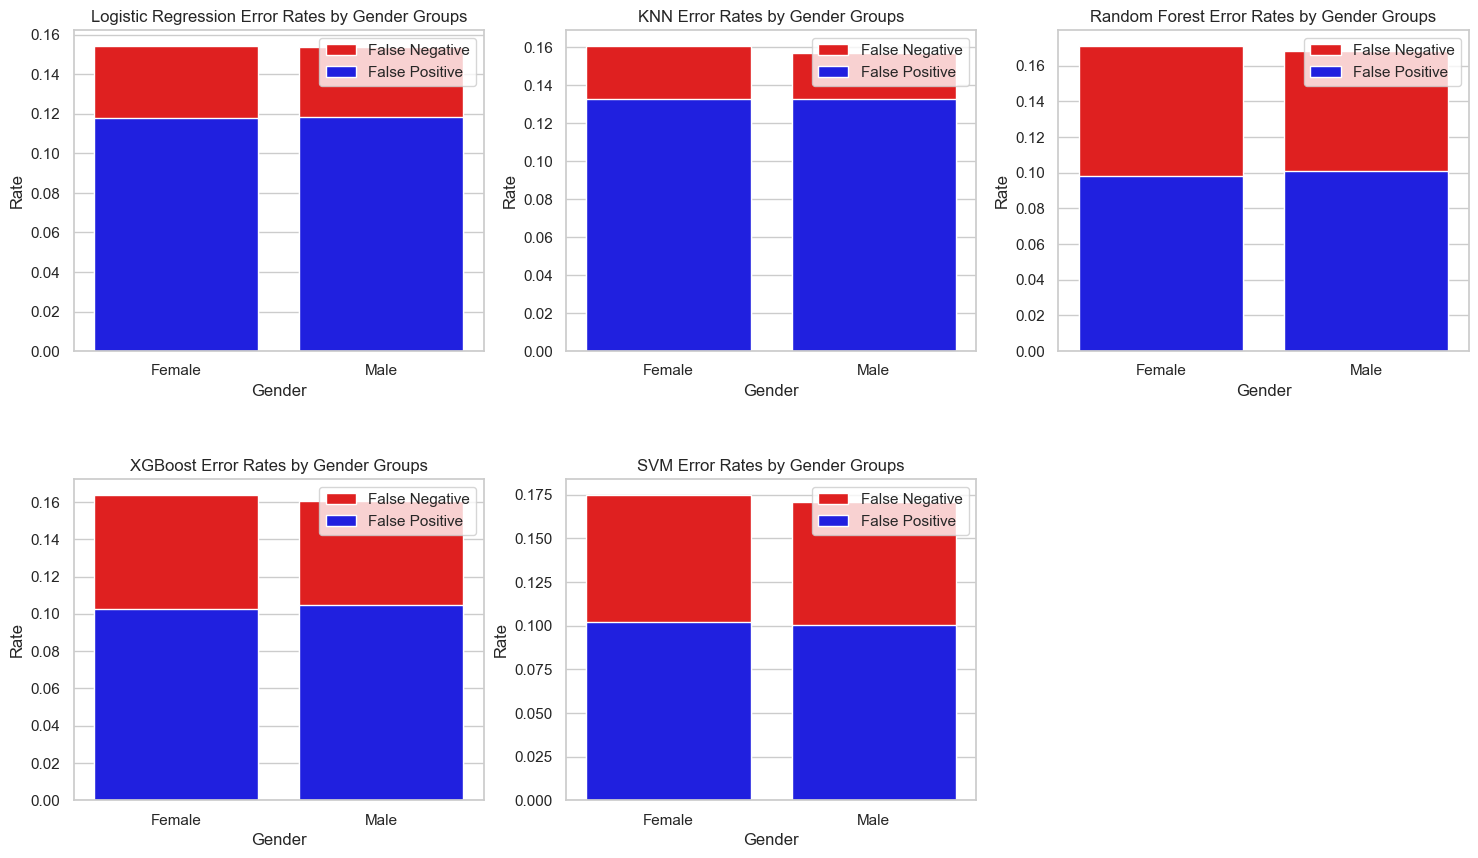

In [256]:
# gender fairness evaluation
gender_groups = test_data['gender'].unique()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, final_models.items()):
    result = pd.DataFrame()

    for group in gender_groups:
        group_name = 'Male' if group == 0 else 'Female'
        group_indices = test_data[test_data['gender'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        result[group_name] = get_results(model, X_group, y_group)
        result.loc['FN_rate', group_name] = ((result[group_name]['y_pred'] == 0) & (y_group == 1)).mean()
        result.loc['FP_rate', group_name] = ((result[group_name]['y_pred'] == 1) & (y_group == 0)).mean()

    gender_group_EOD = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    display(f"{name} - Gender Groups Equal Opportunity Difference (EOD): {gender_group_EOD:.4f}")

    sns.barplot(x=result.columns, y=result.loc['FN_rate'], color="red", label="False Negative", ax=ax)
    sns.barplot(x=result.columns, y=result.loc['FP_rate'], color="blue", label="False Positive", ax=ax)
    ax.set_title(f"{model_name_mapping[name]} Error Rates by Gender Groups")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Rate")

for ax in axes[len(models):]:
    fig.delaxes(ax)

plt.subplots_adjust(hspace=0.4) 
plt.show()

In [257]:
def get_error_groups( y_pred):
    FN_mask = (y_test == 1) & (y_pred == 0)
    FP_mask = (y_test == 0) & (y_pred == 1)
    TP_mask = (y_test == 1) & (y_pred == 1)
    TN_mask = (y_test == 0) & (y_pred == 0)

    return {
        "FN": X_test[FN_mask],
        "FP": X_test[FP_mask],
        "TP": X_test[TP_mask],
        "TN": X_test[TN_mask],
        "FN_idx": FN_mask,
        "FP_idx": FP_mask,
        "TP_idx": TP_mask,
        "TN_idx": TN_mask
    }

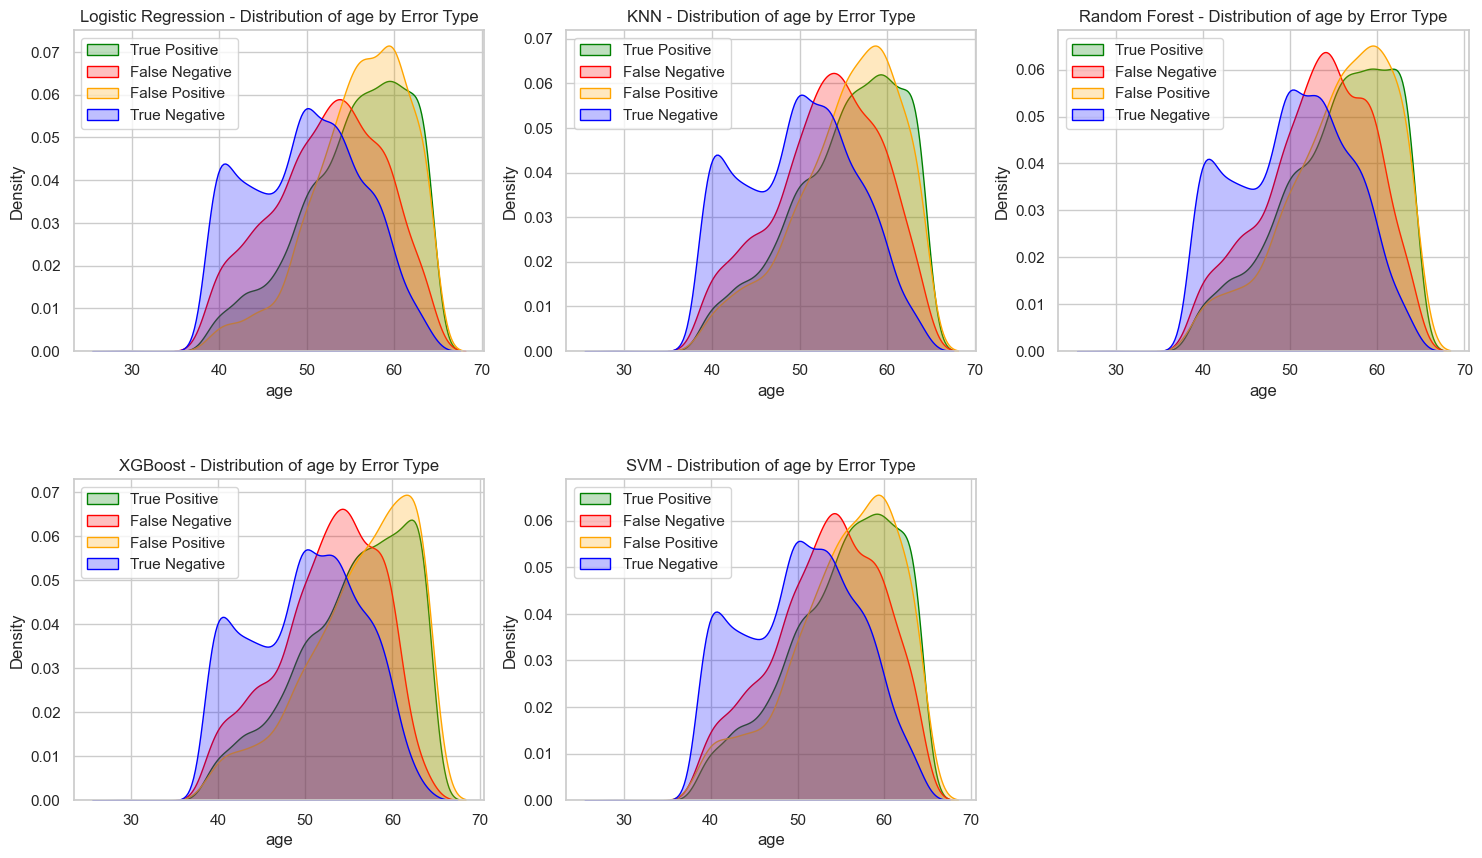

In [258]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, final_results.items()):
    error_groups = get_error_groups(res['y_pred'])

    sns.kdeplot(error_groups["TP"]['age'], label="True Positive", color="green", fill=True, ax=ax)
    sns.kdeplot(error_groups["FN"]['age'], label="False Negative", color="red", fill=True, ax=ax)
    sns.kdeplot(error_groups["FP"]['age'], label="False Positive", color="orange", fill=True, ax=ax)
    sns.kdeplot(error_groups["TN"]['age'], label="True Negative", color="blue", fill=True, ax=ax)
    ax.set_title(f"{model_name_mapping[name]} - Distribution of age by Error Type")
    ax.legend()

for ax in axes[len(models):]:
    fig.delaxes(ax)

plt.subplots_adjust(hspace=0.4) 
plt.show()

***SHAP Explainability Analysis***

In [259]:
def get_shap_summary_df(shap_values, feature_names):
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_summary_df = pd.DataFrame({
        'mean_abs_shap': np.abs(shap_df).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)
    
    return shap_summary_df

Logistic Regression

/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


'Shap Summary Plot for logistic regression'

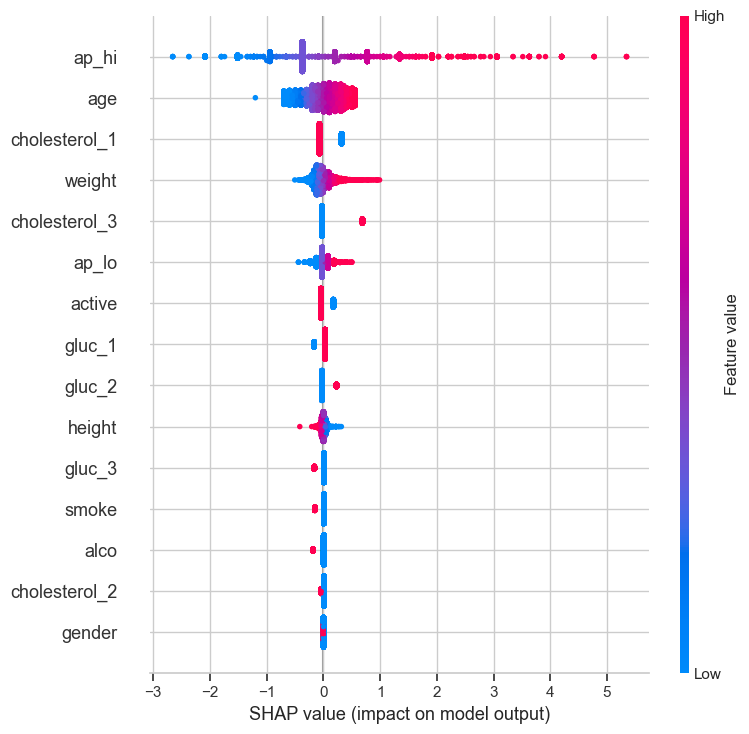

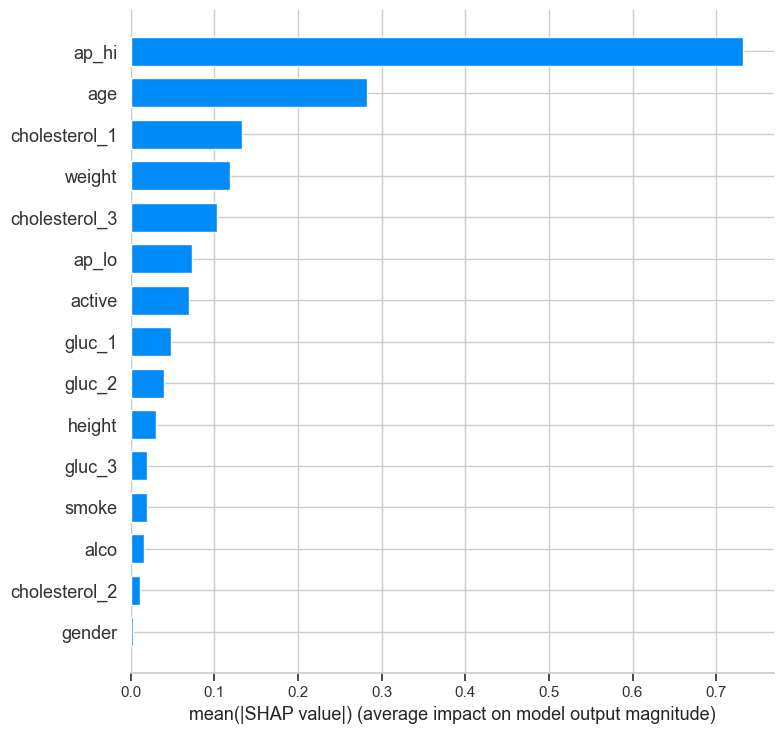

,Feature,Coefficient
3,ap_hi,0.949792
7,cholesterol_3,0.715807
0,age,0.339672
9,gluc_2,0.254261
8,gluc_1,0.192861
2,weight,0.151705
4,ap_lo,0.097632
11,gender,-0.005635
1,height,-0.038790
6,cholesterol_2,-0.046464


,mean_abs_shap
ap_hi,0.732458
age,0.282935
cholesterol_1,0.132663
weight,0.118596
cholesterol_3,0.103846
ap_lo,0.073927
active,0.069971
gluc_1,0.048875
gluc_2,0.040296
height,0.030953


In [260]:
preprocessor_lr = models['logistic_regression'].named_steps['pre']
model_lr = models['logistic_regression'].named_steps['model']

X_train_ = preprocessor_lr.transform(X_train)
X_test_ = preprocessor_lr.transform(X_test)
feature_names_lr = preprocessor_lr.get_feature_names_out()

explainer_lr = shap.LinearExplainer(model_lr, X_train_, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_)

display(f"Shap Summary Plot for logistic regression")
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr)
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr, plot_type="bar")
            
coefficients_df = pd.DataFrame({'Feature': feature_names_lr, 'Coefficient': model_lr.coef_[0]})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
display(coefficients_df)
            
display(get_shap_summary_df(shap_values_lr, feature_names_lr))

XGBoost

'Shap Summary Plot for XGBoost'

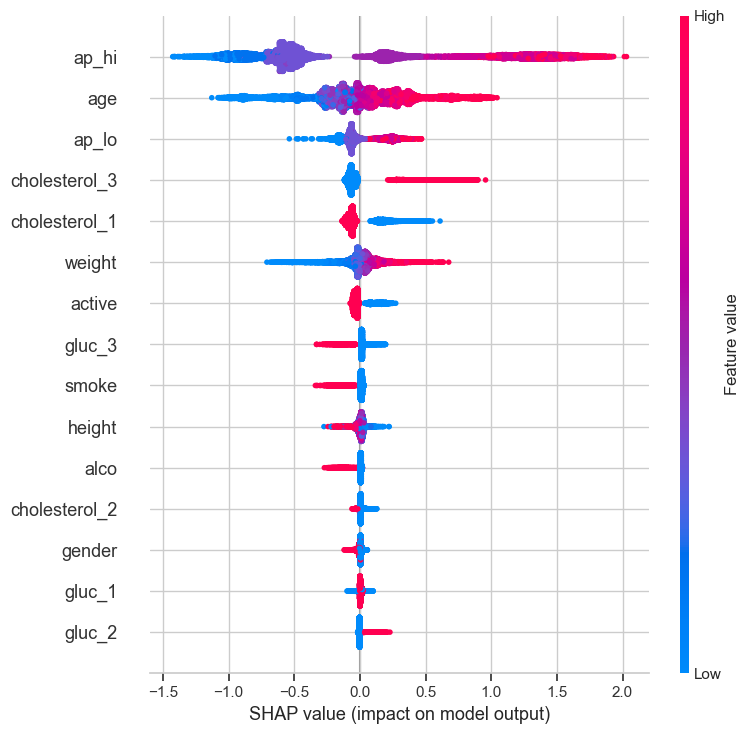

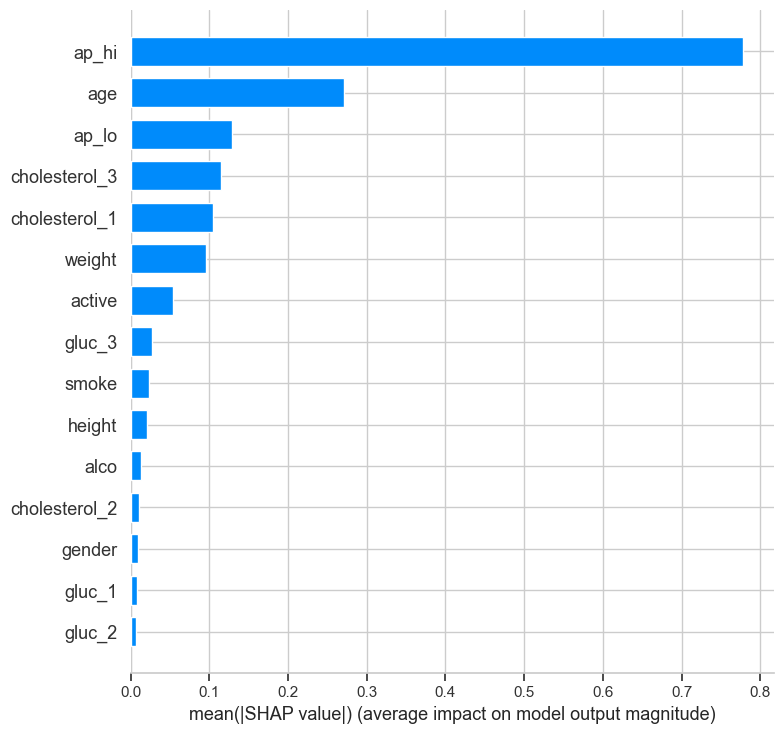

,mean_abs_shap
ap_hi,0.778461
age,0.270602
ap_lo,0.129161
cholesterol_3,0.115372
cholesterol_1,0.104217
weight,0.095244
active,0.053478
gluc_3,0.027798
smoke,0.022790
height,0.021228


In [261]:
preprocessor_xgb = models['xgboost'].named_steps['pre']
model_xgb = models['xgboost'].named_steps['model']

X_test_ = preprocessor_xgb.transform(X_test)
feature_names_xgb = preprocessor_xgb.get_feature_names_out()

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_)

display(f"Shap Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test_, feature_names=feature_names_xgb)
shap.summary_plot(shap_values_xgb, X_test_, feature_names=feature_names_xgb, plot_type="bar")

display(get_shap_summary_df(shap_values_xgb, feature_names_xgb))
